In [1]:
import sys
print(sys.executable)


d:\SWS\envs\ME\python.exe


In [2]:
import os
import sys
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from ydata_profiling import ProfileReport

import warnings
warnings.filterwarnings("ignore")

import lime
import lime.lime_tabular

import pickle
from xgboost import XGBClassifier

from sklearn.tree import plot_tree
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder,OrdinalEncoder
from sklearn.compose import ColumnTransformer
from sklearn.model_selection import GridSearchCV, KFold, train_test_split
from imblearn.over_sampling import SMOTE
from sklearn.metrics import (
          ConfusionMatrixDisplay, confusion_matrix, classification_report,
          accuracy_score,precision_score,recall_score,roc_auc_score,roc_curve,f1_score)
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier, AdaBoostClassifier


# New section

In [3]:
print(sys.executable)


d:\SWS\envs\ME\python.exe


In [6]:
# Read the dataset
df = pd.read_csv('../dataset/data.csv')
df.head()


Age Gender Smoking Hx Smoking Hx Radiothreapy Thyroid Function  \
0   27      F      No         No              No        Euthyroid   
1   34      F      No        Yes              No        Euthyroid   
2   30      F      No         No              No        Euthyroid   
3   62      F      No         No              No        Euthyroid   
4   62      F      No         No              No        Euthyroid   

          Physical Examination Adenopathy       Pathology     Focality Risk  \
0   Single nodular goiter-left         No  Micropapillary    Uni-Focal  Low   
1          Multinodular goiter         No  Micropapillary    Uni-Focal  Low   
2  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
3  Single nodular goiter-right         No  Micropapillary    Uni-Focal  Low   
4          Multinodular goiter         No  Micropapillary  Multi-Focal  Low   

     T   N   M Stage       Response Recurred  
0  T1a  N0  M0     I  Indeterminate       No  
1  T1a  N0  M0     I      Excellent       No  
2  T1a  N0  M0     I      Excellent       No  
3  T1a  N0  M0     I      Excellent       No  
4  T1a  N0  M0     I      Excellent       No

In [7]:
df.shape


(383, 17)

In [8]:
df.columns


Index(['Age', 'Gender', 'Smoking', 'Hx Smoking', 'Hx Radiothreapy',
       'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology',
       'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response', 'Recurred'],
      dtype='object')

In [9]:
df.dtypes


Age                      int64
Gender                  object
Smoking                 object
Hx Smoking              object
Hx Radiothreapy         object
Thyroid Function        object
Physical Examination    object
Adenopathy              object
Pathology               object
Focality                object
Risk                    object
T                       object
N                       object
M                       object
Stage                   object
Response                object
Recurred                object
dtype: object

# Data Preprocessing
## EDA(Exploratory Data Analysis)

In [ ]:
profile = ProfileReport(df)
profile.to_file(output_file='/content/data_profile.html')


Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Export report to file:   0%|          | 0/1 [00:00<?, ?it/s]

In [10]:
def plot_data_graph(data_label):
      plt.figure(figsize=(9, 7))
      if pd.api.types.is_numeric_dtype(df[data_label]) and df[data_label].nunique() > 10:
        sns.histplot(data=df, x=data_label, bins=25, kde=True, color='skyblue')
      else:
        sns.countplot(x=data_label, data=df, palette='pastel', width=0.5)

      if ((df[data_label].astype(str).apply(len) > 15).any()):
         plt.xticks(rotation=30)

      plt.title(f'Count of {data_label}')
      plt.xlabel(data_label)
      plt.ylabel('Count')
      plt.show()


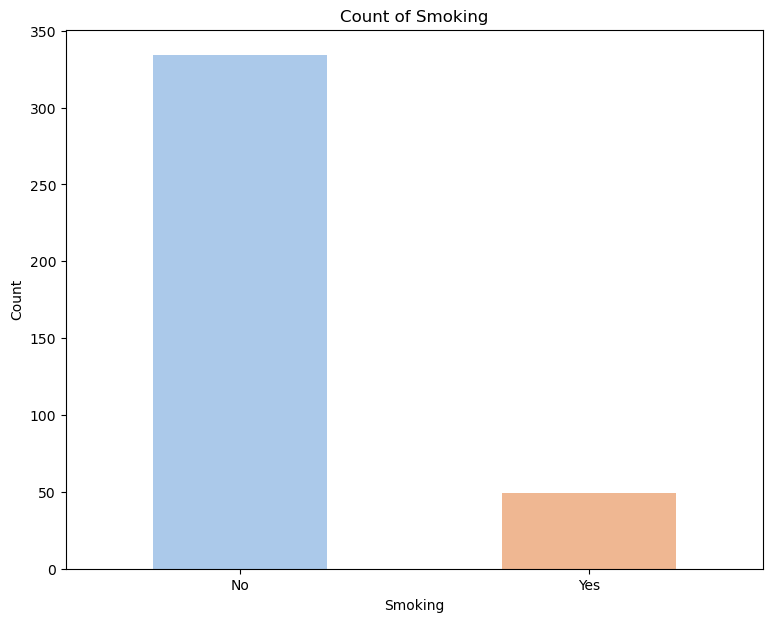

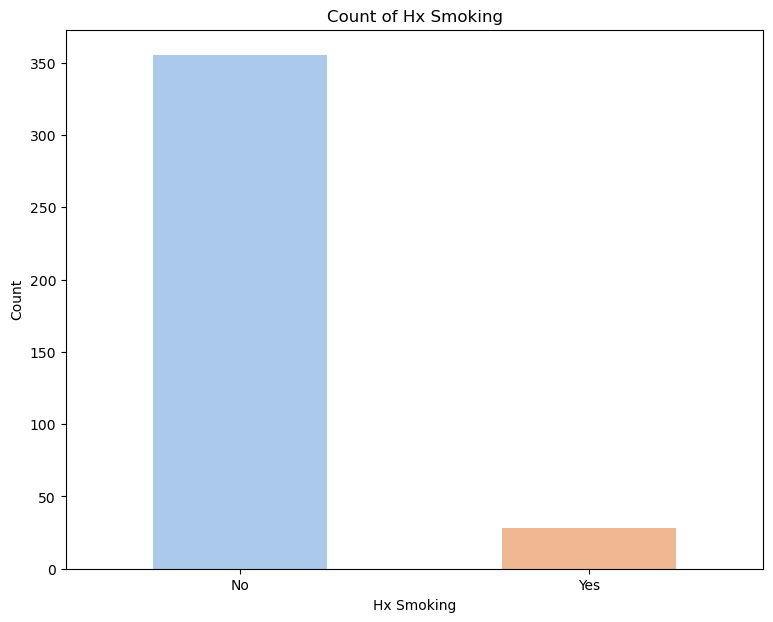

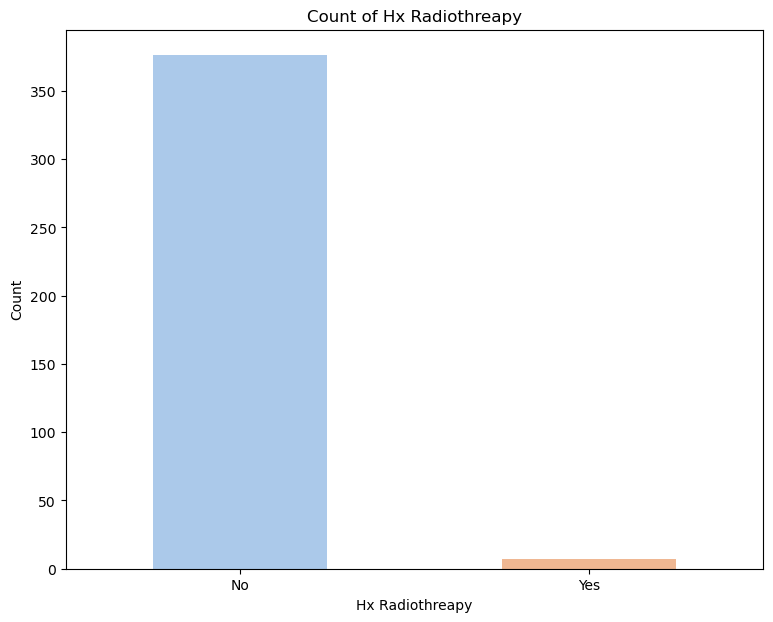

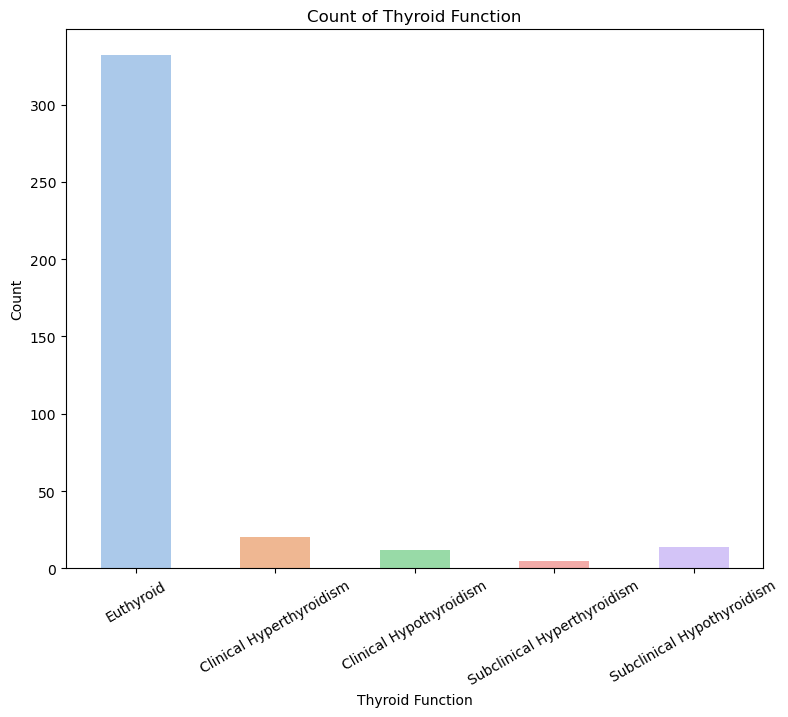

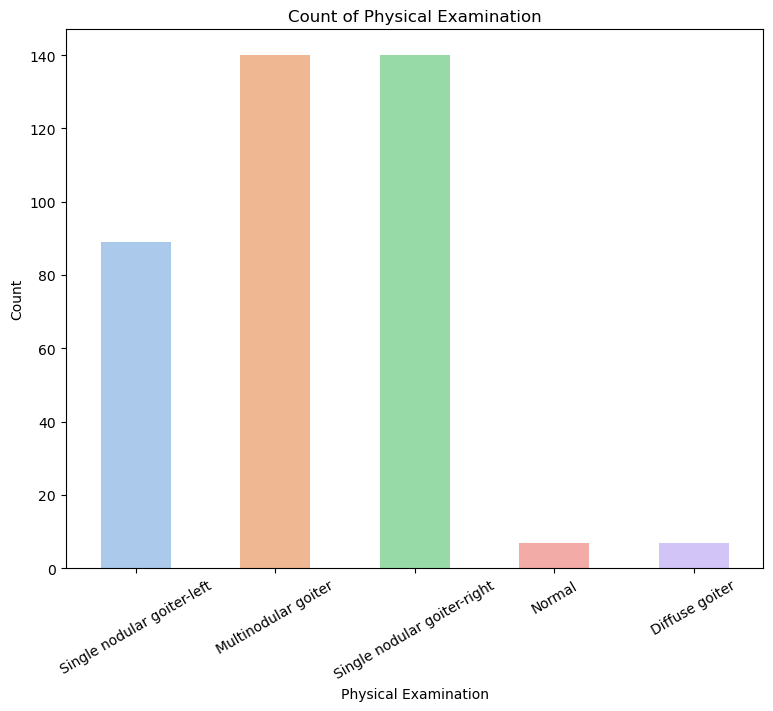

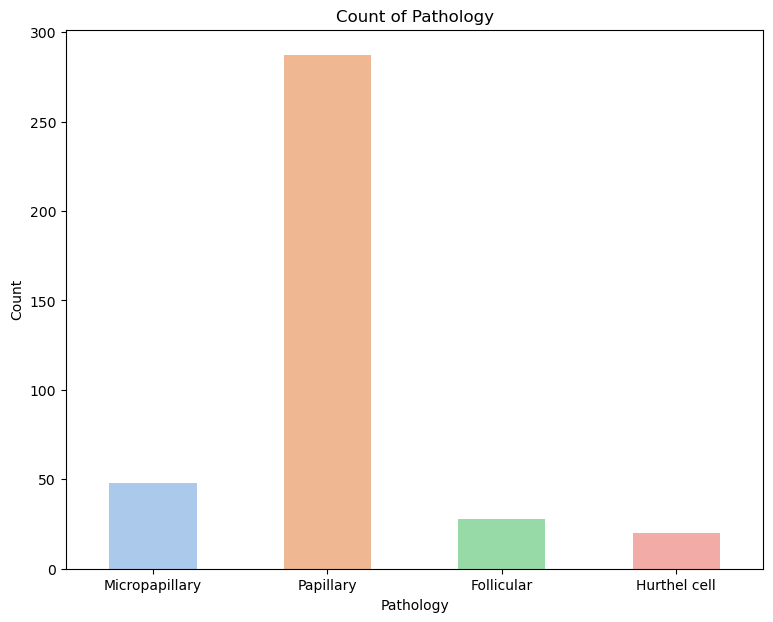

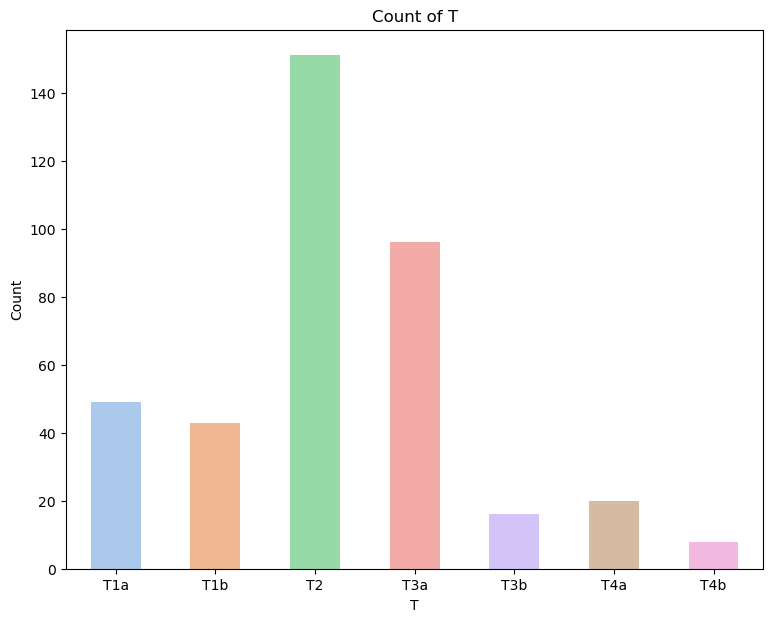

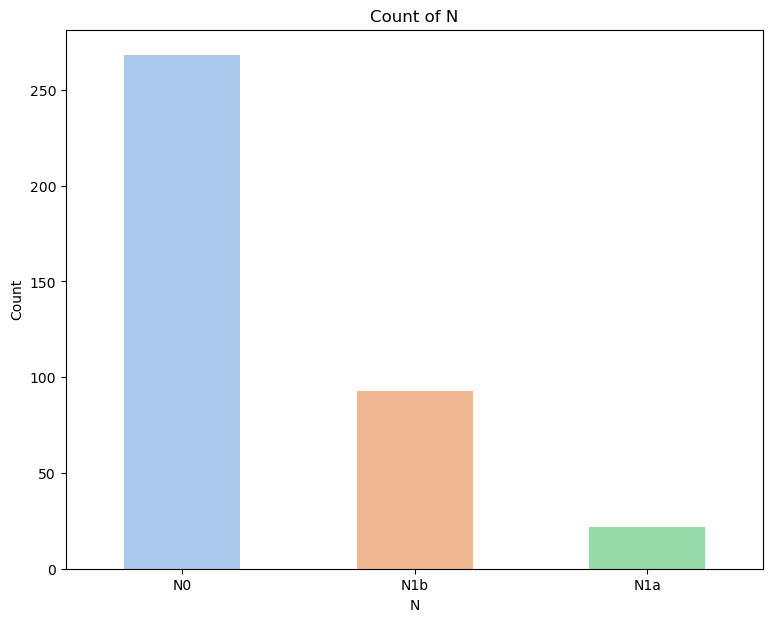

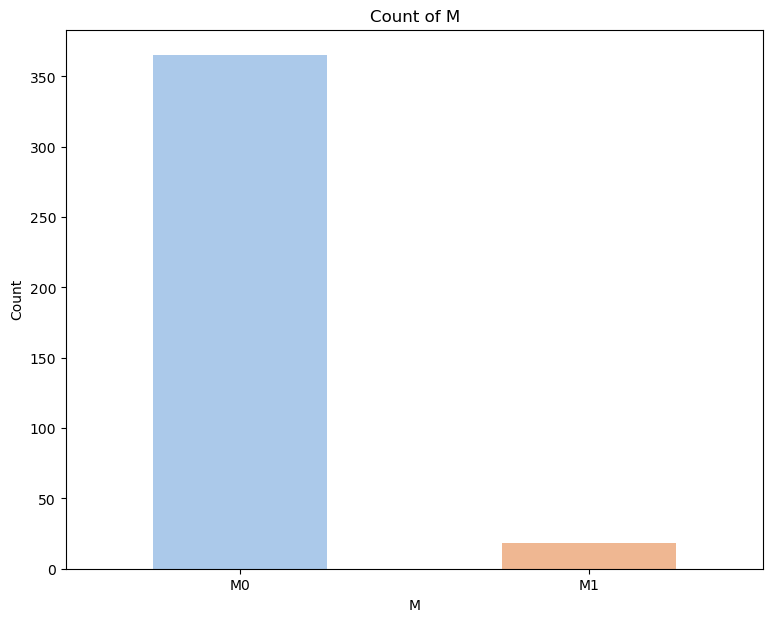

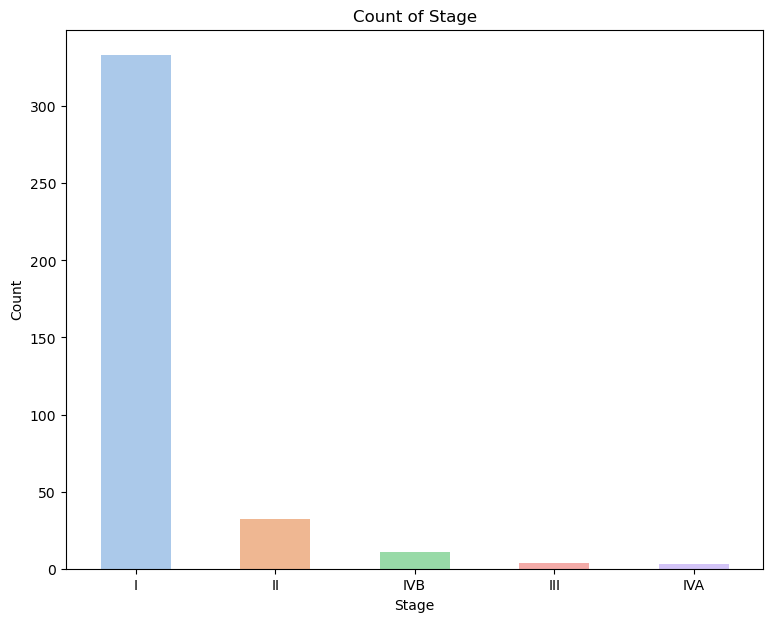

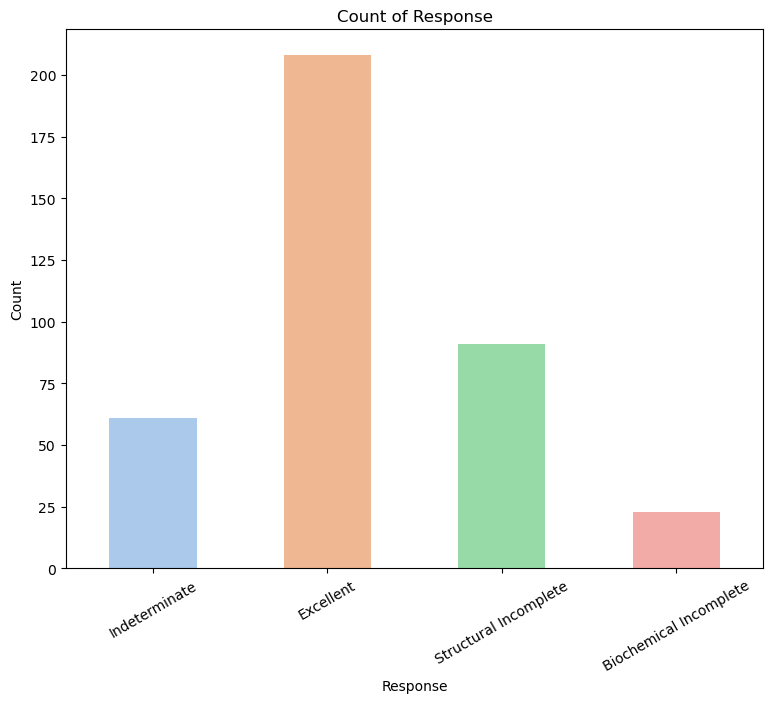

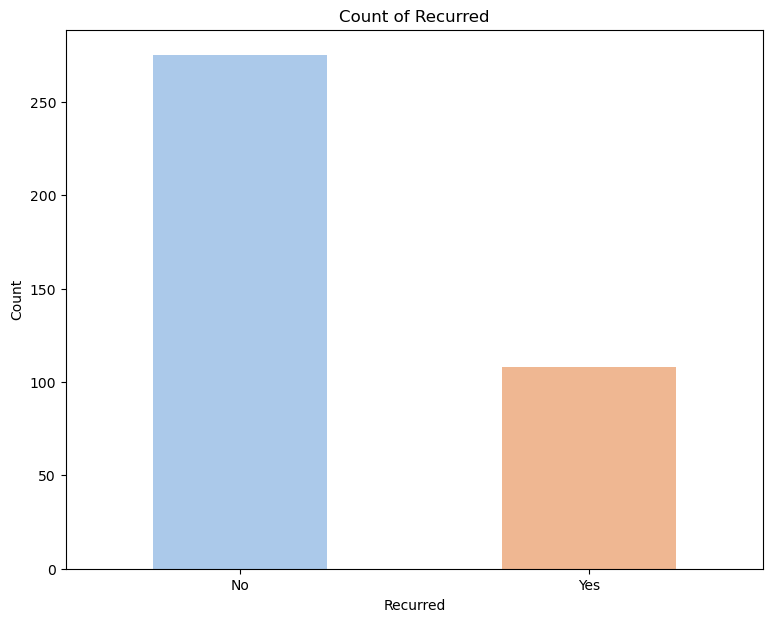

In [11]:
plot_data_graph('Age')
plot_data_graph('Gender')
plot_data_graph('Smoking')
plot_data_graph('Hx Smoking')
plot_data_graph('Hx Radiothreapy')
plot_data_graph('Thyroid Function')
plot_data_graph('Physical Examination')
plot_data_graph('Adenopathy')
plot_data_graph('Pathology')
plot_data_graph('Focality')
plot_data_graph('Risk')
plot_data_graph('T')
plot_data_graph('N')
plot_data_graph('M')
plot_data_graph('Stage')
plot_data_graph('Response')
plot_data_graph('Recurred')


In [12]:
def plot_recurrence_data(data_label):
     plt.figure(figsize=(10, 6))
     sns.countplot(x=data_label, hue='Recurred', data=df, palette='Blues')

     if ((df[data_label].astype(str).apply(len) > 15).any()):
         plt.xticks(rotation=30)

     plt.title(f'Recurrence Count for Each {data_label}', fontsize=16, weight='bold')
     plt.xlabel(data_label, fontsize=14)
     plt.ylabel('Count', fontsize=14)
     plt.legend(title='Recurred', title_fontsize='12', fontsize='10')


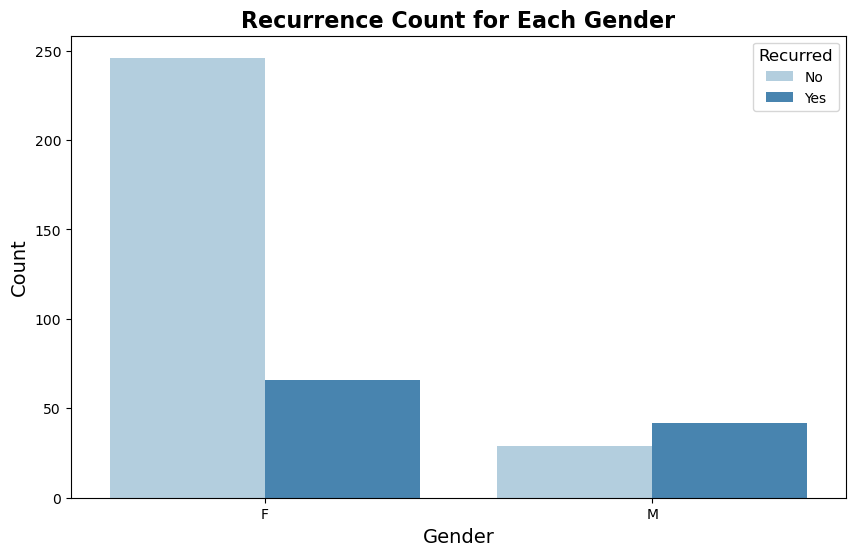

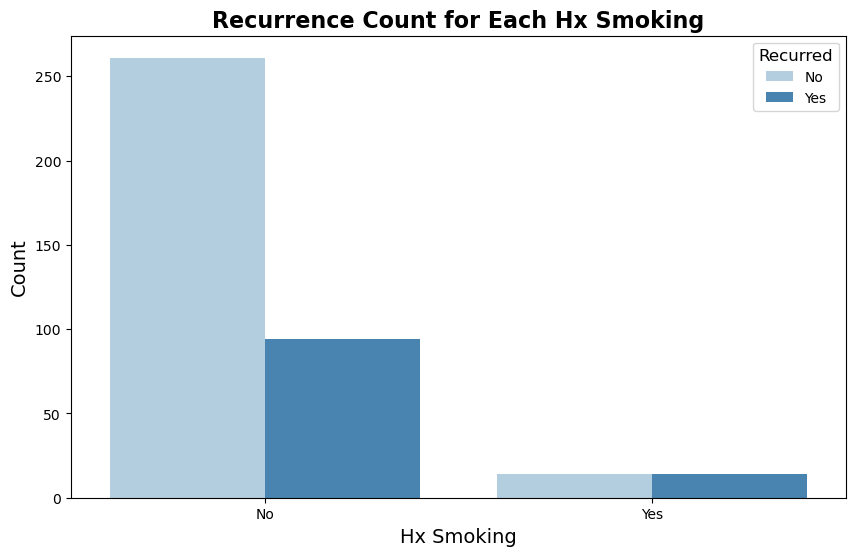

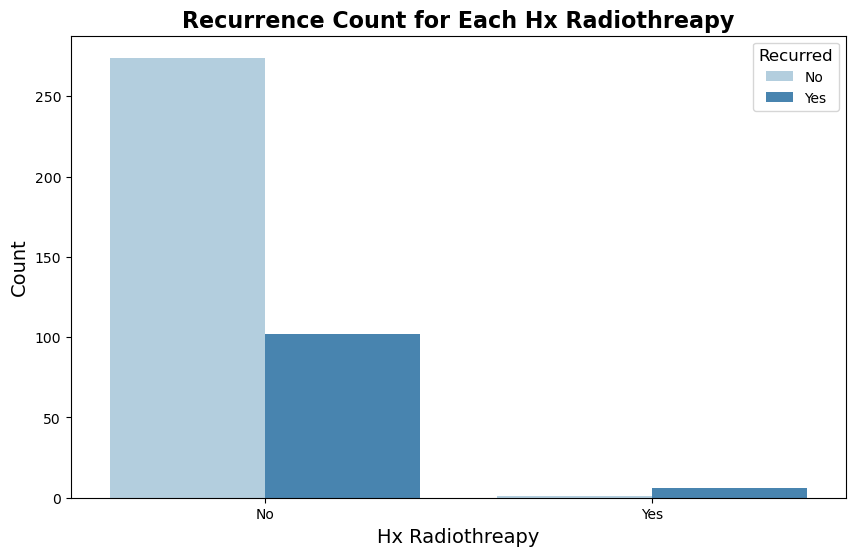

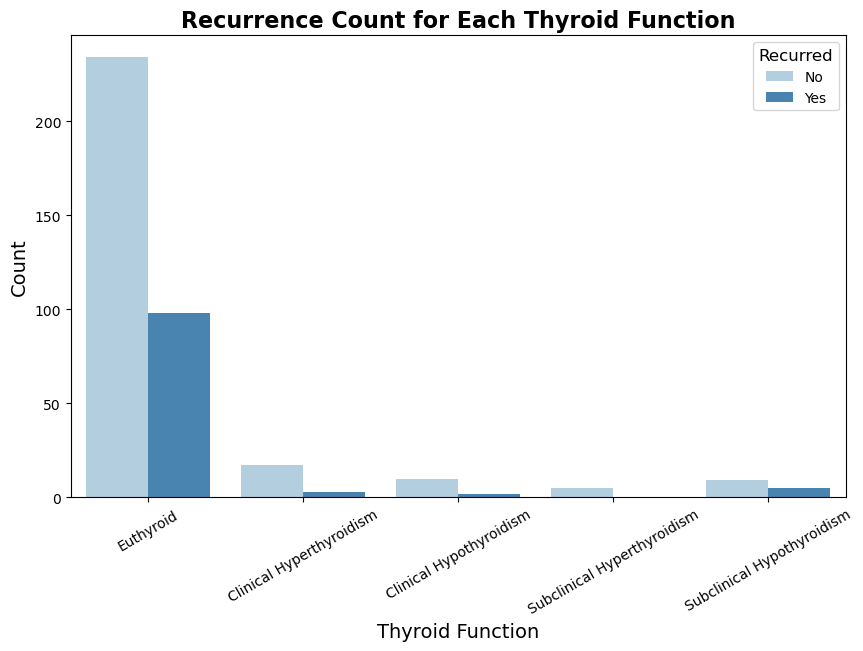

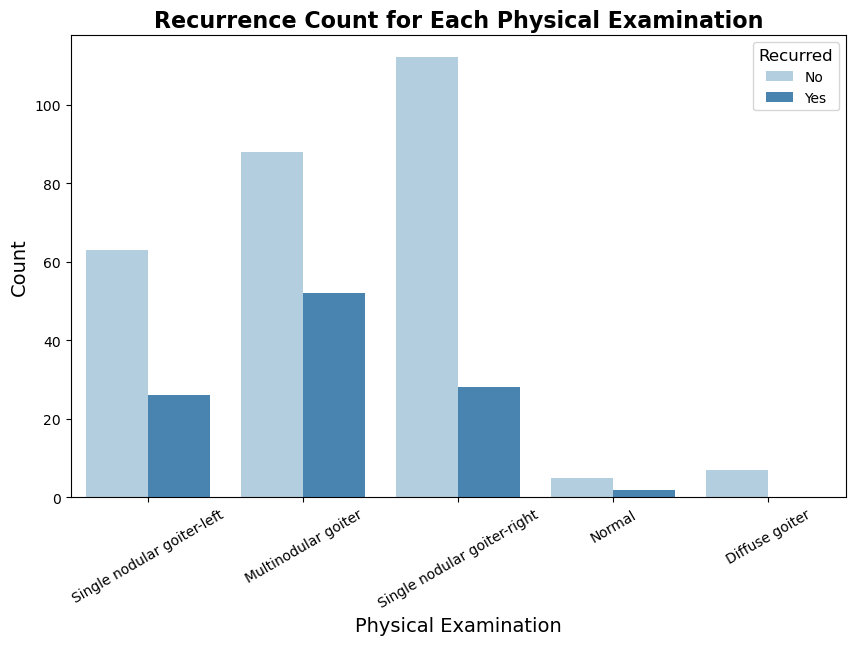

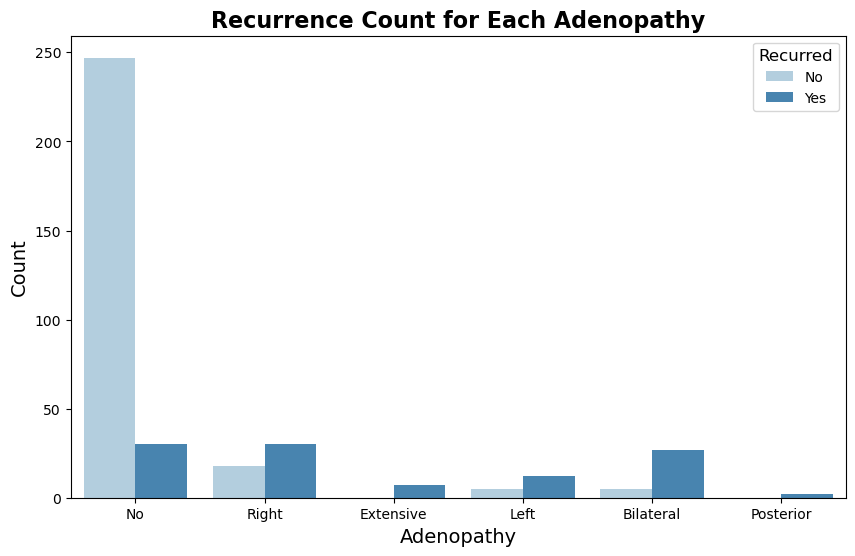

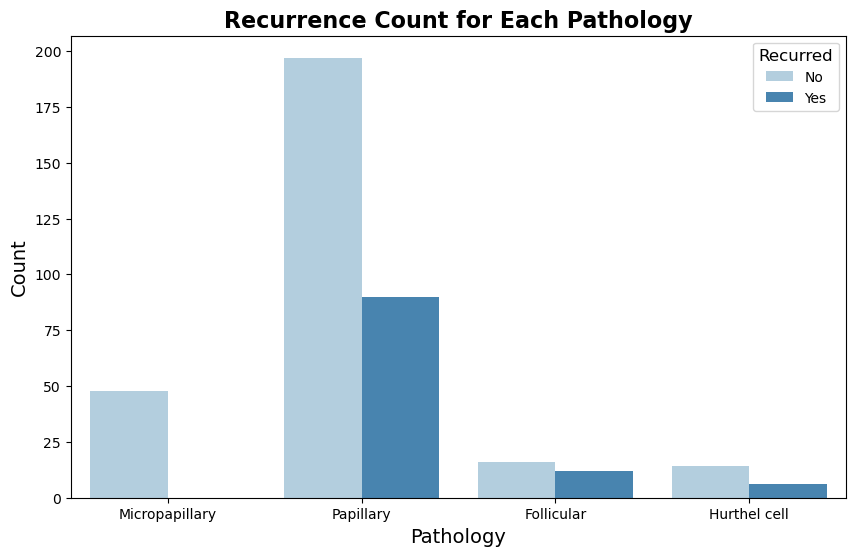

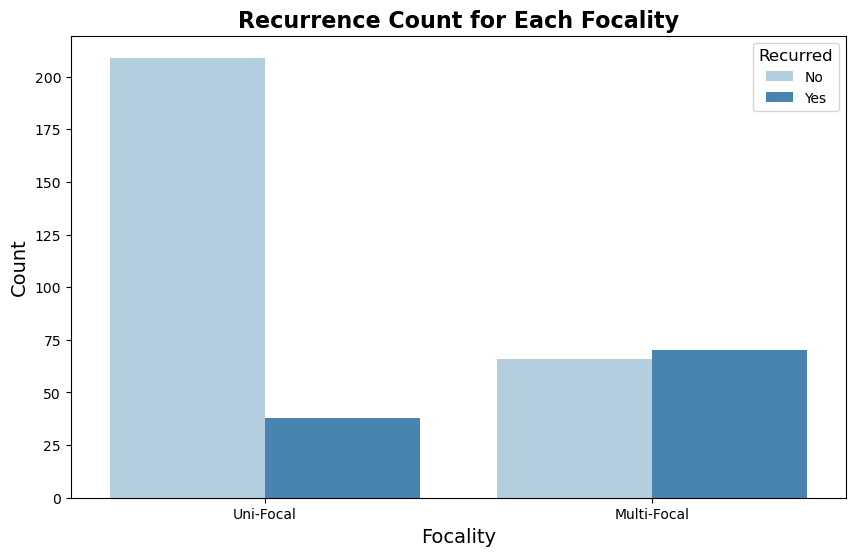

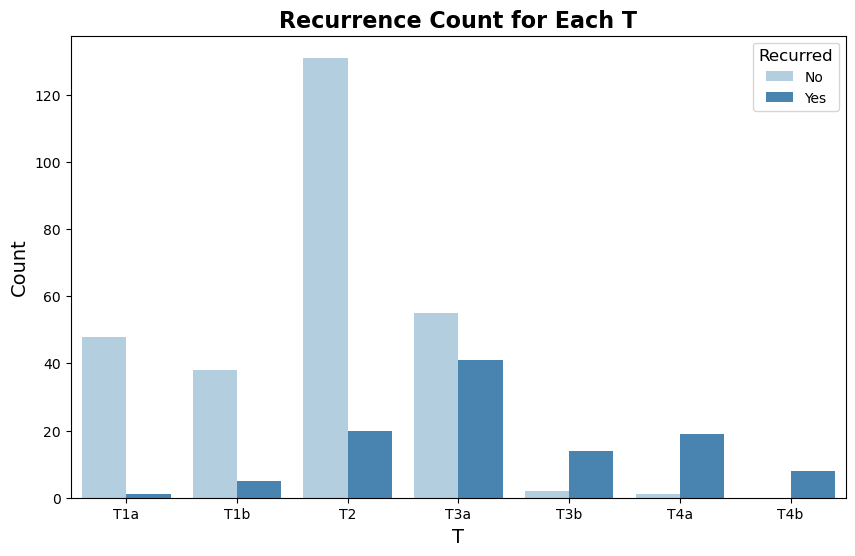

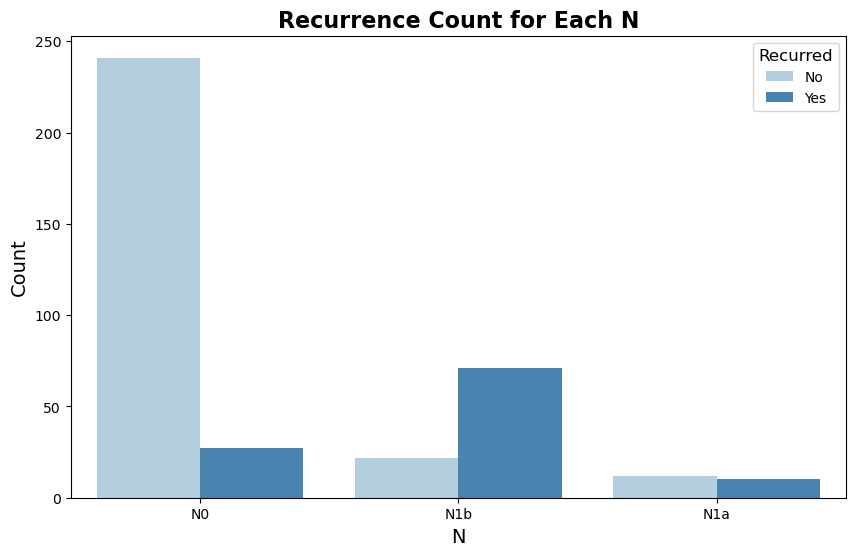

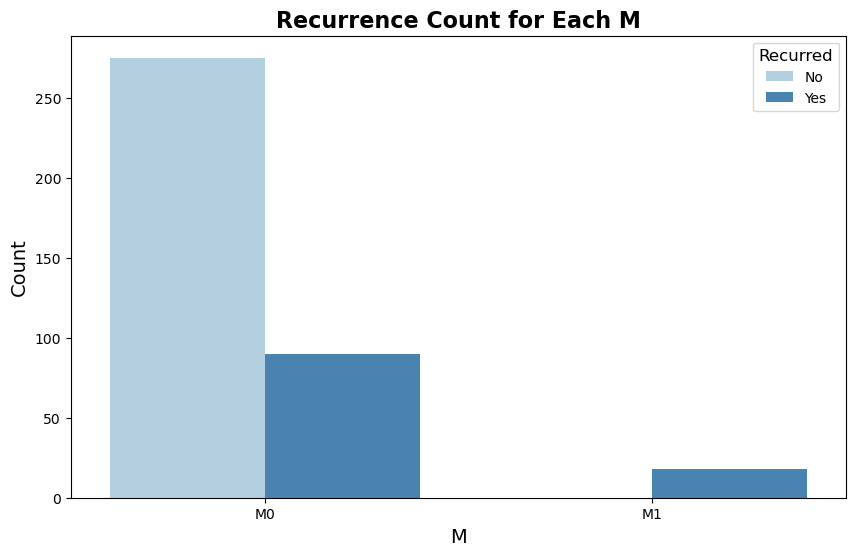

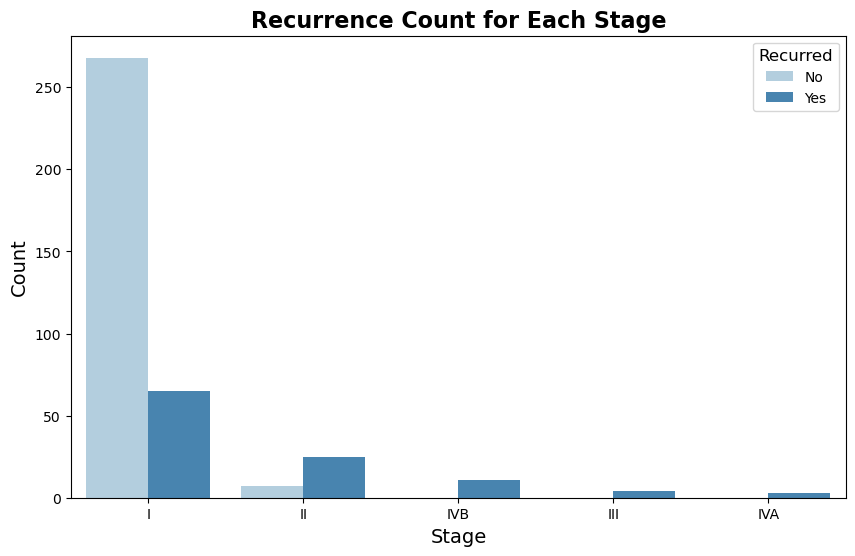

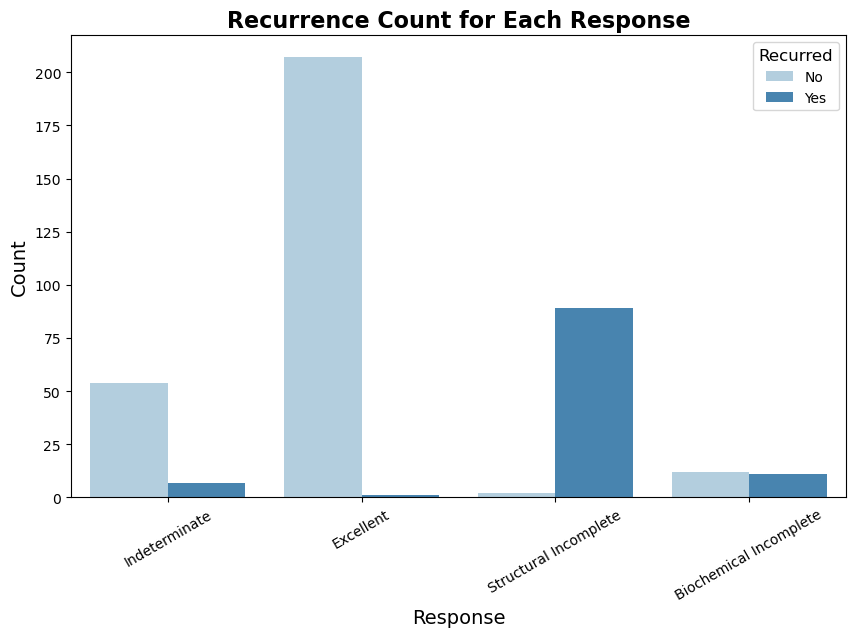

In [13]:
plot_recurrence_data('Gender')
plot_recurrence_data('Smoking')
plot_recurrence_data('Hx Smoking')
plot_recurrence_data('Hx Radiothreapy')
plot_recurrence_data('Thyroid Function')
plot_recurrence_data('Physical Examination')
plot_recurrence_data('Adenopathy')
plot_recurrence_data('Pathology')
plot_recurrence_data('Focality')
plot_recurrence_data('Risk')
plot_recurrence_data('T')
plot_recurrence_data('N')
plot_recurrence_data('M')
plot_recurrence_data('Stage')
plot_recurrence_data('Response')


In [14]:
df = df.drop_duplicates()


In [354]:
df.shape


(364, 17)

In [355]:
categorical = ['Gender', 'Thyroid Function', 'Physical Examination', 'Adenopathy', 'Pathology']
ordinal = ['Smoking', 'Hx Smoking', 'Hx Radiothreapy', 'Focality', 'Risk', 'T', 'N', 'M', 'Stage', 'Response']
numeric = ['Age']

transformer = ColumnTransformer(
     transformers= [
          ('catagorical', OneHotEncoder(drop='first', handle_unknown='ignore'), categorical),
          ('ordinal', OrdinalEncoder(categories=[['No', 'Yes'], ['No', 'Yes'], ['No', 'Yes'],['Uni-Focal','Multi-Focal'], ['Low','Intermediate','High'], ['T1a', 'T1b', 'T2', 'T3a', 'T3b', 'T4a', 'T4b'],
                                                 ['N0','N1a','N1b'], ['M0','M1'],['I', 'II', 'IVB', 'III', 'IVA'], ['Excellent', 'Indeterminate', 'Biochemical Incomplete','Structural Incomplete']]), ordinal),
          ('numeric', StandardScaler(), numeric)
     ],
     remainder='passthrough'
)


In [356]:
X = df.drop("Recurred",axis=1)


In [357]:
y = df['Recurred'].map({"No": 0 , "Yes":1})


In [358]:
X_transformed = transformer.fit_transform(X)


In [359]:
X_transformed.shape


(364, 28)

In [360]:
transformed_feature_names = transformer.get_feature_names_out(input_features=X.columns)
print(transformed_feature_names)
print(len(transformed_feature_names))


['catagorical__Gender_M'
 'catagorical__Thyroid Function_Clinical Hypothyroidism'
 'catagorical__Thyroid Function_Euthyroid'
 'catagorical__Thyroid Function_Subclinical Hyperthyroidism'
 'catagorical__Thyroid Function_Subclinical Hypothyroidism'
 'catagorical__Physical Examination_Multinodular goiter'
 'catagorical__Physical Examination_Normal'
 'catagorical__Physical Examination_Single nodular goiter-left'
 'catagorical__Physical Examination_Single nodular goiter-right'
 'catagorical__Adenopathy_Extensive' 'catagorical__Adenopathy_Left'
 'catagorical__Adenopathy_No' 'catagorical__Adenopathy_Posterior'
 'catagorical__Adenopathy_Right' 'catagorical__Pathology_Hurthel cell'
 'catagorical__Pathology_Micropapillary'
 'catagorical__Pathology_Papillary' 'ordinal__Smoking'
 'ordinal__Hx Smoking' 'ordinal__Hx Radiothreapy' 'ordinal__Focality'
 'ordinal__Risk' 'ordinal__T' 'ordinal__N' 'ordinal__M' 'ordinal__Stage'
 'ordinal__Response' 'numeric__Age']
28


In [361]:
ohe_features = transformer.named_transformers_['catagorical'].get_feature_names_out(categorical)
ordinal_features = ordinal
numeric_features = numeric

final_feature_names = list(ohe_features) + ordinal_features + numeric_features

final_feature_names


['Gender_M',
 'Thyroid Function_Clinical Hypothyroidism',
 'Thyroid Function_Euthyroid',
 'Thyroid Function_Subclinical Hyperthyroidism',
 'Thyroid Function_Subclinical Hypothyroidism',
 'Physical Examination_Multinodular goiter',
 'Physical Examination_Normal',
 'Physical Examination_Single nodular goiter-left',
 'Physical Examination_Single nodular goiter-right',
 'Adenopathy_Extensive',
 'Adenopathy_Left',
 'Adenopathy_No',
 'Adenopathy_Posterior',
 'Adenopathy_Right',
 'Pathology_Hurthel cell',
 'Pathology_Micropapillary',
 'Pathology_Papillary',
 'Smoking',
 'Hx Smoking',
 'Hx Radiothreapy',
 'Focality',
 'Risk',
 'T',
 'N',
 'M',
 'Stage',
 'Response',
 'Age']

In [362]:
transformed_df = pd.DataFrame(data=X_transformed,columns=final_feature_names)
print(transformed_df.shape)
transformed_df['Recurred'] = y
print(transformed_df.shape)
transformed_df.head()


(364, 28)
(364, 29)


Gender_M  Thyroid Function_Clinical Hypothyroidism  \
0       0.0                                       0.0   
1       0.0                                       0.0   
2       0.0                                       0.0   
3       0.0                                       0.0   
4       0.0                                       0.0   

   Thyroid Function_Euthyroid  Thyroid Function_Subclinical Hyperthyroidism  \
0                         1.0                                           0.0   
1                         1.0                                           0.0   
2                         1.0                                           0.0   
3                         1.0                                           0.0   
4                         1.0                                           0.0   

   Thyroid Function_Subclinical Hypothyroidism  \
0                                          0.0   
1                                          0.0   
2                                          0.0   
3                                          0.0   
4                                          0.0   

   Physical Examination_Multinodular goiter  Physical Examination_Normal  \
0                                       0.0                          0.0   
1                                       1.0                          0.0   
2                                       0.0                          0.0   
3                                       0.0                          0.0   
4                                       1.0                          0.0   

   Physical Examination_Single nodular goiter-left  \
0                                              1.0   
1                                              0.0   
2                                              0.0   
3                                              0.0   
4                                              0.0   

   Physical Examination_Single nodular goiter-right  Adenopathy_Extensive  \
0                                               0.0                   0.0   
1                                               0.0                   0.0   
2                                               1.0                   0.0   
3                                               1.0                   0.0   
4                                               0.0                   0.0   

   ...  Hx Radiothreapy  Focality  Risk    T    N    M  Stage  Response  \
0  ...              0.0       0.0   0.0  0.0  0.0  0.0    0.0       1.0   
1  ...              0.0       0.0   0.0  0.0  0.0  0.0    0.0       0.0   
2  ...              0.0       0.0   0.0  0.0  0.0  0.0    0.0       0.0   
3  ...              0.0       0.0   0.0  0.0  0.0  0.0    0.0       0.0   
4  ...              0.0       1.0   0.0  0.0  0.0  0.0    0.0       0.0   

        Age  Recurred  
0 -0.931780       0.0  
1 -0.474064       0.0  
2 -0.735616       0.0  
3  1.356803       0.0  
4  1.356803       0.0  

[5 rows x 29 columns]

In [363]:
X_train,X_test,y_train,y_test = train_test_split(X_transformed,y,test_size=0.3,random_state=1)


In [364]:
X_test,X_val,y_test,y_val = train_test_split(X_test,y_test,test_size=0.5,random_state=1)


# Model Train

In [25]:
def evaluate_model (true, pred):
    print("Model Evaluation: \n")
    accuracy = accuracy_score(true, pred)
    precision = precision_score(true, pred)
    recall = recall_score(true, pred)
    roc = roc_auc_score(true, pred)
    f1 = f1_score(true, pred)
    print("Accuracy of the model is: %.2f"%(accuracy * 100) , "%")
    print("Precision of the model is: %.2f" %(precision * 100) , "%")
    print("Recall of the model is: %.2f" %(recall * 100) , "%")
    print("AUC value of the model is: %.2f" %(roc * 100) , "%")
    print("F1 score of the model is: %.2f" %(f1 * 100) , "%")


In [74]:
labels = ['norecurreance', 'recurreance']
def plot_cm_cr(y_true, y_pred, title=None): 
     print("\nClassification Report: \n") 
     report_text = classification_report(y_test, y_pred, target_names=labels)
     fig, ax = plt.subplots(figsize=(8, 2))
     plt.title(f"{title} Classification Report", ha='center', fontsize=13, weight='bold', pad=30)
     ax.axis('off')
     ax.text(0, 1, report_text, fontsize=12, fontfamily='monospace', verticalalignment='top')
     plt.show()
     

     print("\nConfusion Matrix: \n")
     cm = confusion_matrix(y_true, y_pred)
     plt.figure(figsize=(10,8))
     plt.title(f"{title} Confusion Matrix", fontsize=13, weight='bold', pad=30)
     sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
     plt.xlabel('Predicted Label', labelpad=20, fontsize=14)
     plt.ylabel('Truth Label', labelpad=20, fontsize=14)
     plt.show()


In [365]:
scaler = StandardScaler()


In [366]:
X_train_scaled = scaler.fit_transform(X_train)
X_train_scaled.shape


(254, 28)

In [367]:
X_test_scaled = scaler.transform(X_test)
X_test_scaled.shape


(55, 28)

In [368]:
X_val_scaled = scaler.transform(X_val)
X_val_scaled.shape


(55, 28)

In [25]:
dt = DecisionTreeClassifier()


In [26]:
dt.fit(X_train_scaled,y_train)


DecisionTreeClassifier()

In [27]:
y_pred_dt = dt.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 96.49 %
Precision of the model is: 90.00 %
Recall of the model is: 100.00 %
AUC value of the model is: 97.44 %
F1 score of the model is: 94.74 %

Classification Report: 

               precision    recall  f1-score   support

           0       1.00      0.95      0.97        39
           1       0.90      1.00      0.95        18

    accuracy                           0.96        57
   macro avg       0.95      0.97      0.96        57
weighted avg       0.97      0.96      0.97        57


Confusion Matrix: 



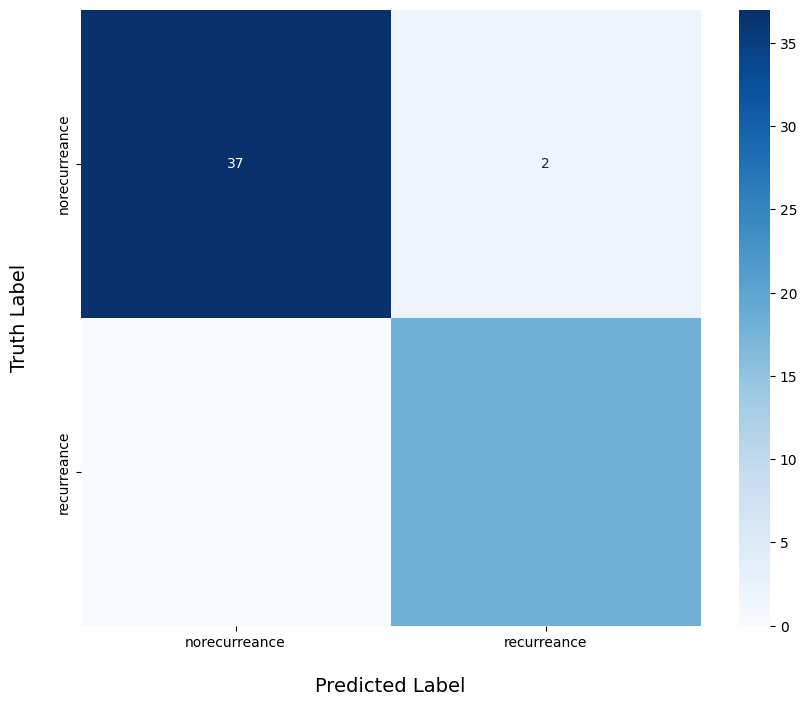

In [ ]:
evaluate_model(y_test,y_pred_dt)
print("\nClassification Report: \n\n",classification_report(y_test,y_pred_dt))
plot_cm_cr(y_test, y_pred_dt)


In [ ]:
output_path = '../output/models'


In [29]:
# save model
def save_model(output_path, model_name, model):
    n = 1
    n=+1
    with open(f'{output_path}/{model_name}_{n}.pkl', 'wb') as file:
        pickle.dump(dt, file)



In [505]:
# load model
def load_model(model_path):
    with open(model_path, 'rb') as file:
        loaded_model = pickle.load(file)
        return loaded_model


In [506]:

load_dt_model = load_model('../output/models/decision_tree_model_0.pkl')
predictions = load_dt_model.predict(X_test_scaled)



Model Evaluation: 

Accuracy of the model is: 92.73 %
Precision of the model is: 93.33 %
Recall of the model is: 82.35 %
AUC value of the model is: 89.86 %
F1 score of the model is: 87.50 %

Classification Report: 



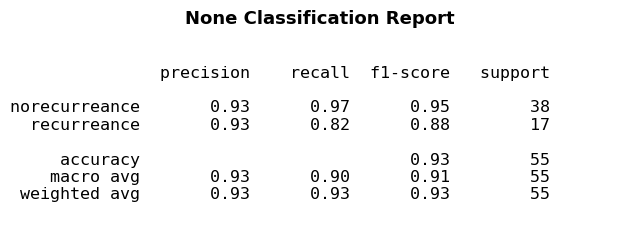


Confusion Matrix: 



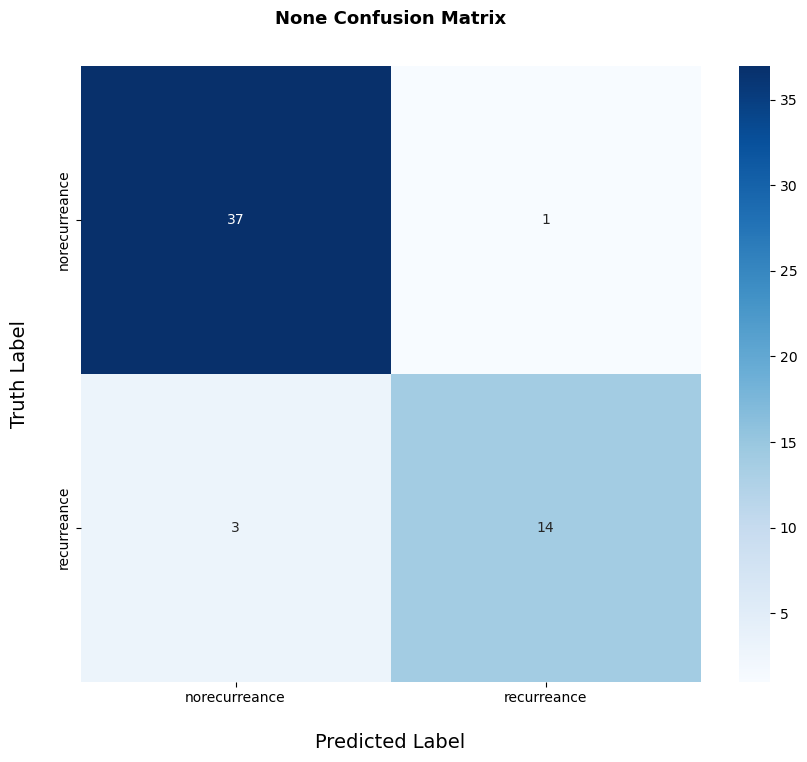

In [507]:
evaluate_model(y_test, predictions)
plot_cm_cr(y_test, predictions)


## KFold Traing


In [440]:
def kf_train(model, X, y, transformer, scaler, n_split=5):
     kf = KFold(n_splits=n_split, shuffle=True, random_state=42)

     avg = []

     for fold, (train_index, test_index) in enumerate(kf.split(X, y)):
          X_train_kf, X_test_kf = X.iloc[train_index], X.iloc[test_index]
          y_train_kf, y_test_kf = y.iloc[train_index], y.iloc[test_index]

          X_train_kf_tf = transformer.fit_transform(X_train_kf)
          X_test_kf_tf = transformer.transform(X_test_kf)
          X_train_kf_scl = scaler.fit_transform(X_train_kf_tf)
          X_test_kf_scl = scaler.transform(X_test_kf_tf)

          model.fit(X_train_kf_scl, y_train_kf)
          preds = model.predict(X_test_kf_scl)
          acc = accuracy_score(y_test_kf, preds)
          avg.append(acc)

          print(f"Fold {fold + 1}: Accuracy score: {acc:.2f}")

     print(f"Average accuracy score : {sum(avg)/len(avg):.2f}")


In [ ]:
kf_train(rf, X, y, transformer, scaler, n_split=5)


Fold 1: Accuracy score: 0.96
Fold 2: Accuracy score: 0.97
Fold 3: Accuracy score: 0.97
Fold 4: Accuracy score: 0.96
Fold 5: Accuracy score: 0.97
Average accuracy score : 0.97


0.9722222222222222

## XAI using LIME

In [287]:
explainer = lime.lime_tabular.LimeTabularExplainer(
    training_data=X_train_scaled,
    mode='classification',
    feature_names=final_feature_names,
    class_names=['Not Recurred', 'Recurred'],
    discretize_continuous=True
)


In [288]:
X_train_scaled.shape[1]


28

In [307]:
def exp_lime(model):
    exp = explainer.explain_instance(
        X_test_scaled[11],
        model.predict_proba,
        num_features=len(feature_names)
    )
    return exp


In [443]:
def plot_exp(exp, title=None):
    feature_importances = exp.as_list()

    features, importances = zip(*feature_importances)

    colors = sns.color_palette("pastel")

    plt.figure(figsize=(10, 8))
    plt.barh(features, importances, color=colors)

    plt.xlabel('Importance')
    plt.title(f'{title} LIME Feature Importance' if title else "LIME Feature Importance")

    textstr = (
           f'{exp.class_names[0]}: {exp.predict_proba[0]:.2f}\n'
           f'{exp.class_names[1]}: {exp.predict_proba[1]:.2f}')

    plt.gca().text(0.75, 0.90, textstr,
                   transform=plt.gca().transAxes,
                   fontsize=12,
                   verticalalignment='bottom',
                   bbox=dict(boxstyle='round,pad=0.4', facecolor='lightblue', alpha=0.6))


    plt.grid(False)
    plt.show()


#### Decision Tree

In [491]:
dt = DecisionTreeClassifier()


In [492]:
dt.fit(X_train_scaled,y_train)


DecisionTreeClassifier()

In [493]:
y_pred_dt = dt.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 92.73 %
Precision of the model is: 93.33 %
Recall of the model is: 82.35 %
AUC value of the model is: 89.86 %
F1 score of the model is: 87.50 %

Classification Report: 



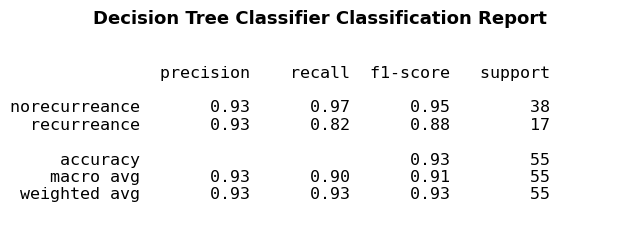


Confusion Matrix: 



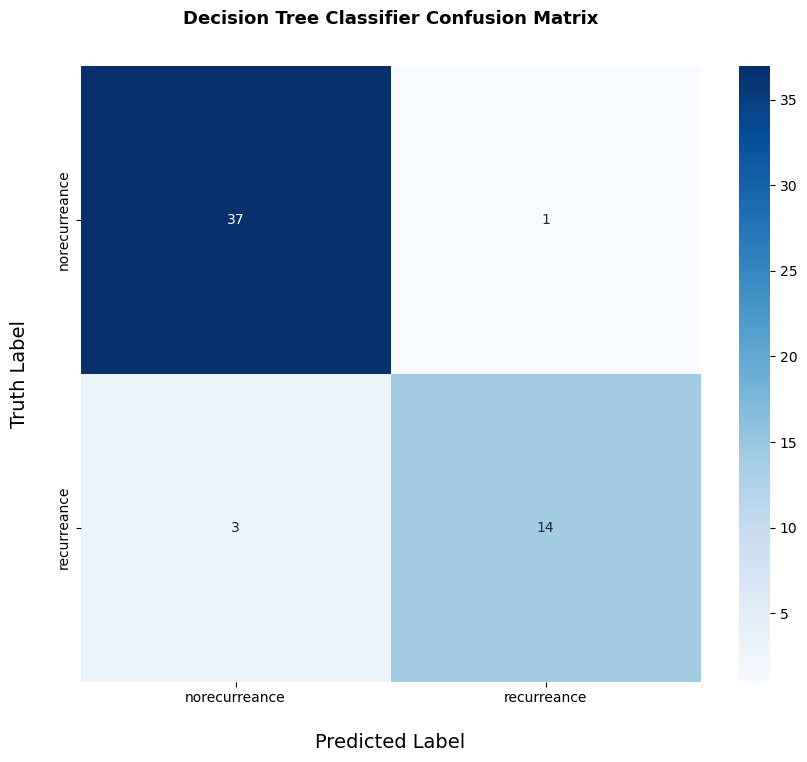

In [497]:
evaluate_model(y_test,y_pred_dt)
plot_cm_cr(y_test, y_pred_dt, "Decision Tree Classifier")


In [495]:
def draw_decision_tree(decision_tree, feature_names=None, class_names=None):
    plt.figure(figsize=(50, 25))
    plot_tree(decision_tree, feature_names=feature_names, class_names=class_names, filled=True)
    plt.show()


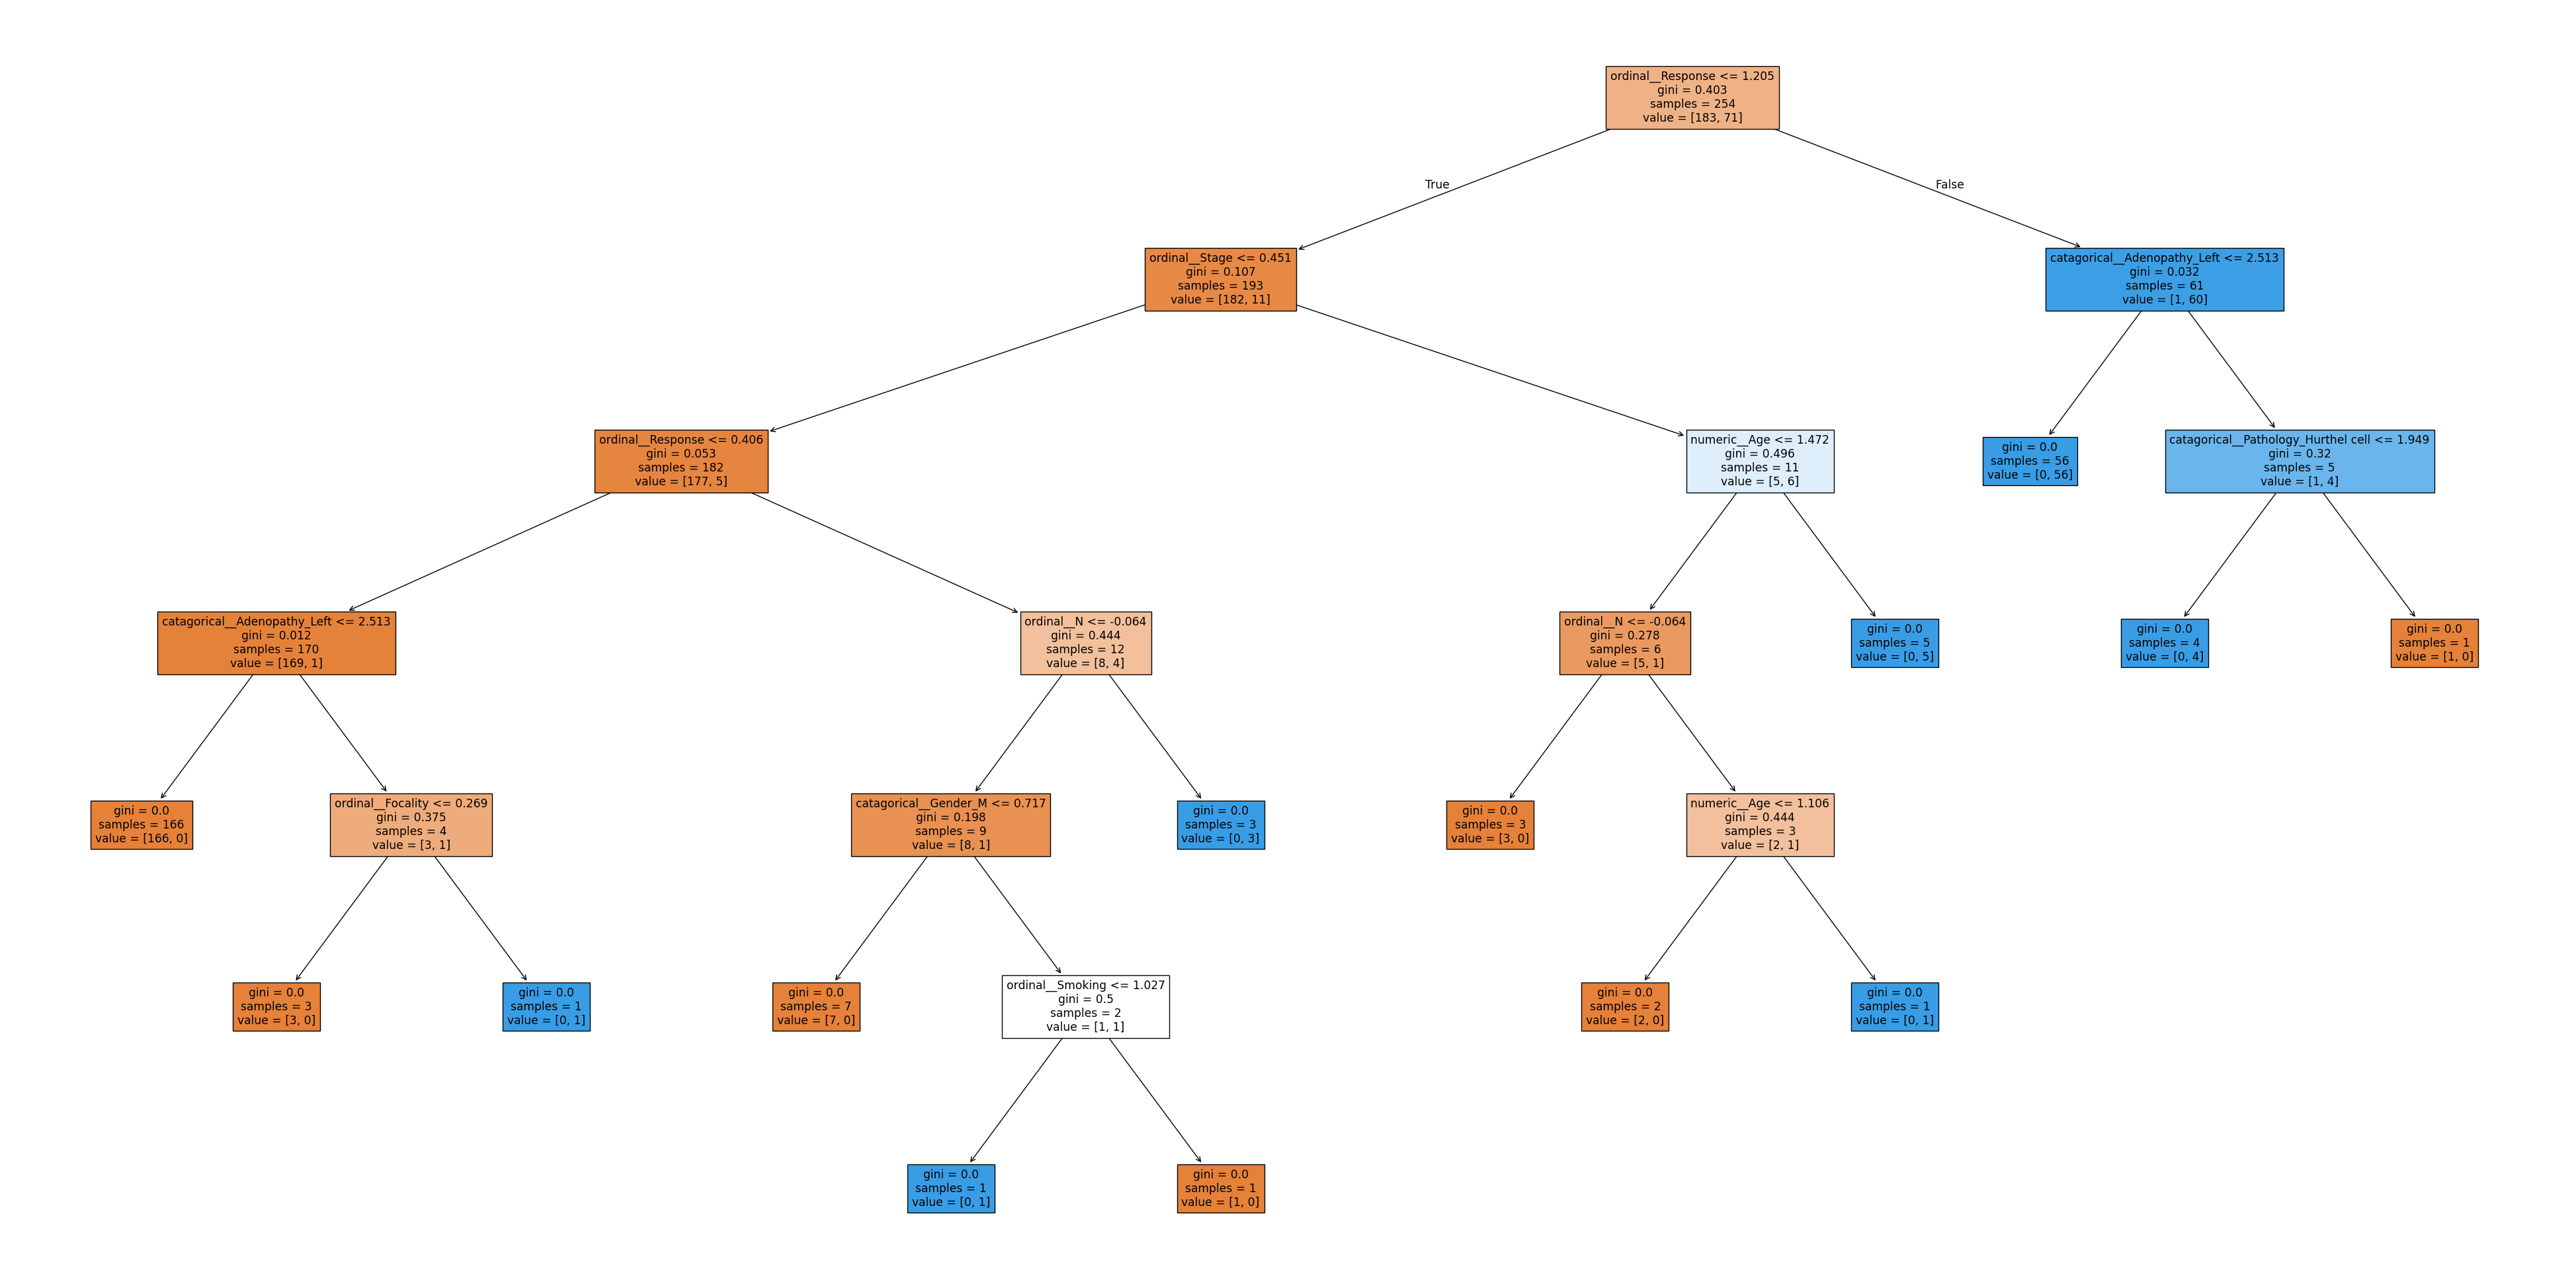

In [496]:
feature_names = [str(name) for name in transformed_feature_names]
draw_decision_tree(dt, feature_names=feature_names)


In [498]:
kf_train(DecisionTreeClassifier(), X, y, transformer, scaler)


Fold 1: Accuracy score: 0.95
Fold 2: Accuracy score: 0.92
Fold 3: Accuracy score: 0.95
Fold 4: Accuracy score: 0.92
Fold 5: Accuracy score: 0.94
Average accuracy score : 0.93


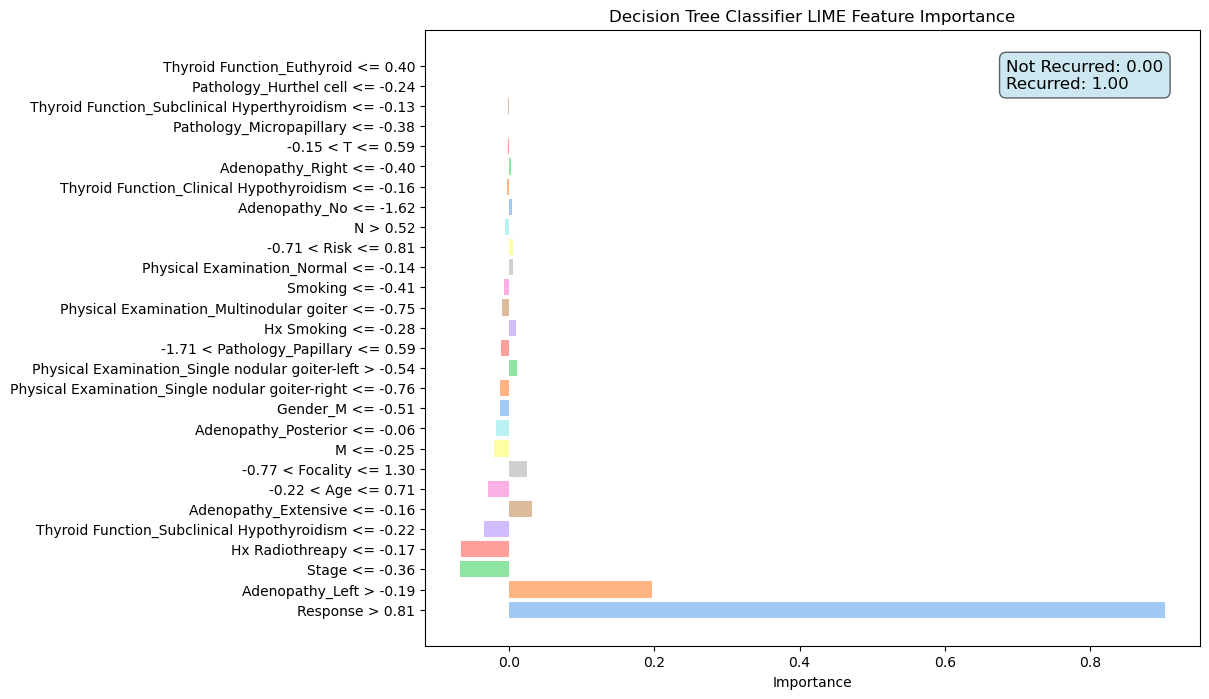

In [499]:
plot_exp(exp_lime(dt), "Decision Tree Classifier")


In [500]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train_scaled, y_train)


In [501]:
dt.fit(X_resampled, y_resampled)


DecisionTreeClassifier()

In [502]:
y_pred_dt_1 = dt.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 92.73 %
Precision of the model is: 93.33 %
Recall of the model is: 82.35 %
AUC value of the model is: 89.86 %
F1 score of the model is: 87.50 %

Classification Report: 



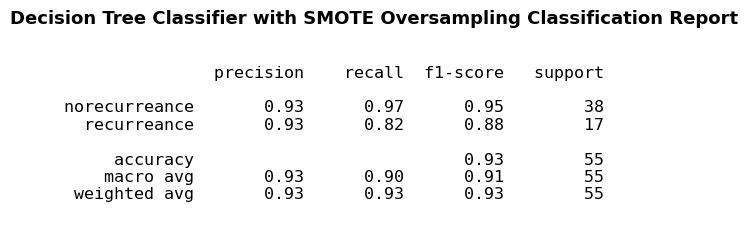


Confusion Matrix: 



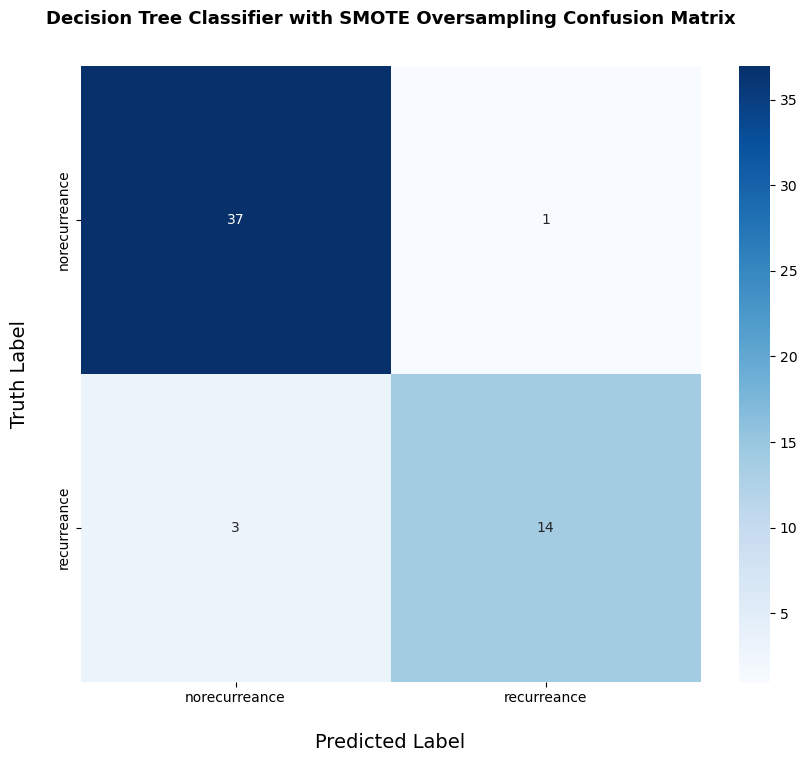

In [503]:
evaluate_model(y_test, y_pred_dt_1)
plot_cm_cr(y_test, y_pred_dt_1, "Decision Tree Classifier with SMOTE Oversampling")


RANDOM FOREST

In [253]:
rf = RandomForestClassifier(random_state=42)
n_estimators = [100, 300, 500]
criterion = ['gini', 'entropy']
max_depth = [None, 10, 30]
max_features = ['sqrt', 'log2']
bootstrap = [True, False]
class_weight = [None, 'balanced']
rf_param_grid = dict(n_estimators=n_estimators,criterion=criterion, max_depth=max_depth,max_features=max_features,bootstrap=bootstrap,class_weight=class_weight)
grid_search_rf = GridSearchCV(estimator=rf, param_grid=rf_param_grid, n_jobs=-1,cv=10,scoring='roc_auc',error_score=0)


In [255]:
grid_result_rf = grid_search_rf.fit(X_val_scaled, y_val)


In [256]:
print("Highest ROC AUC is achieved using the parameters : ", grid_result_rf.best_params_)
rf.set_params(**grid_result_rf.best_params_)


Highest ROC AUC is achieved using the parameters :  {'bootstrap': False, 'class_weight': 'balanced', 'criterion': 'gini', 'max_depth': None, 'max_features': 'log2', 'n_estimators': 100}


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features='log2', random_state=42)

In [257]:
rf.fit(X_train_scaled, y_train)


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features='log2', random_state=42)

In [267]:
print("Model trained on:", rf.n_features_in_) 


Model trained on: 28


In [259]:
y_pred_rf = rf.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 92.73 %
Precision of the model is: 100.00 %
Recall of the model is: 76.47 %
AUC value of the model is: 88.24 %
F1 score of the model is: 86.67 %

Classification Report: 



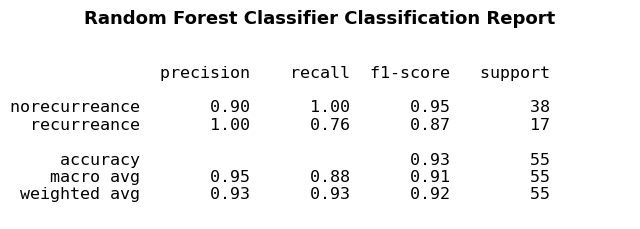


Confusion Matrix: 



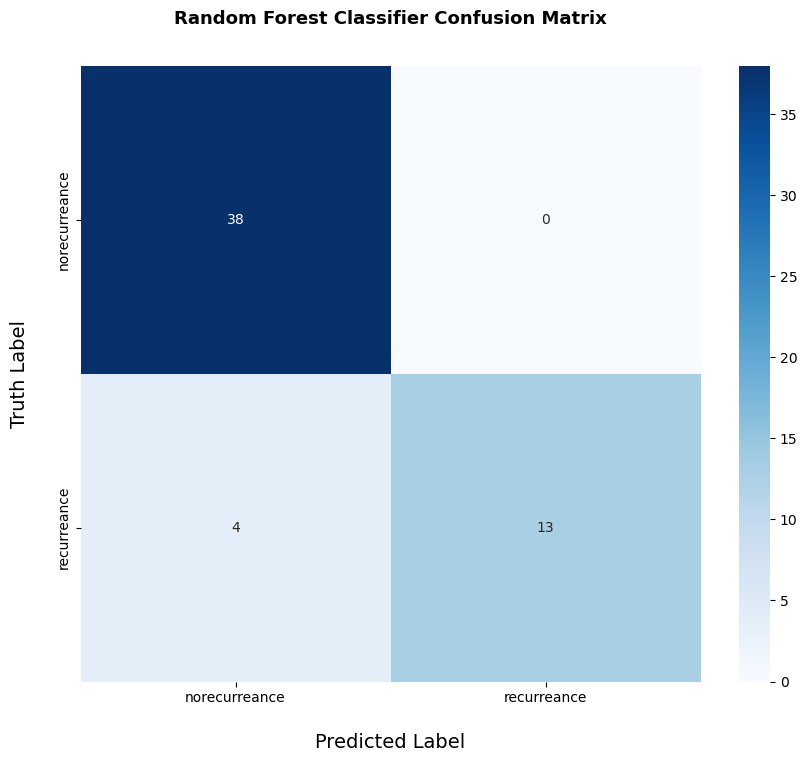

In [260]:

evaluate_model(y_test, y_pred_rf)
plot_cm_cr(y_test, y_pred_rf, "Random Forest Classifier")


In [265]:
kf_rf = kf_train(RandomForestClassifier(random_state=42), X, y, transformer, scaler)


Fold 1: Accuracy score: 0.96
Fold 2: Accuracy score: 0.96
Fold 3: Accuracy score: 0.96
Fold 4: Accuracy score: 0.96
Fold 5: Accuracy score: 0.97
Average accuracy score : 0.96


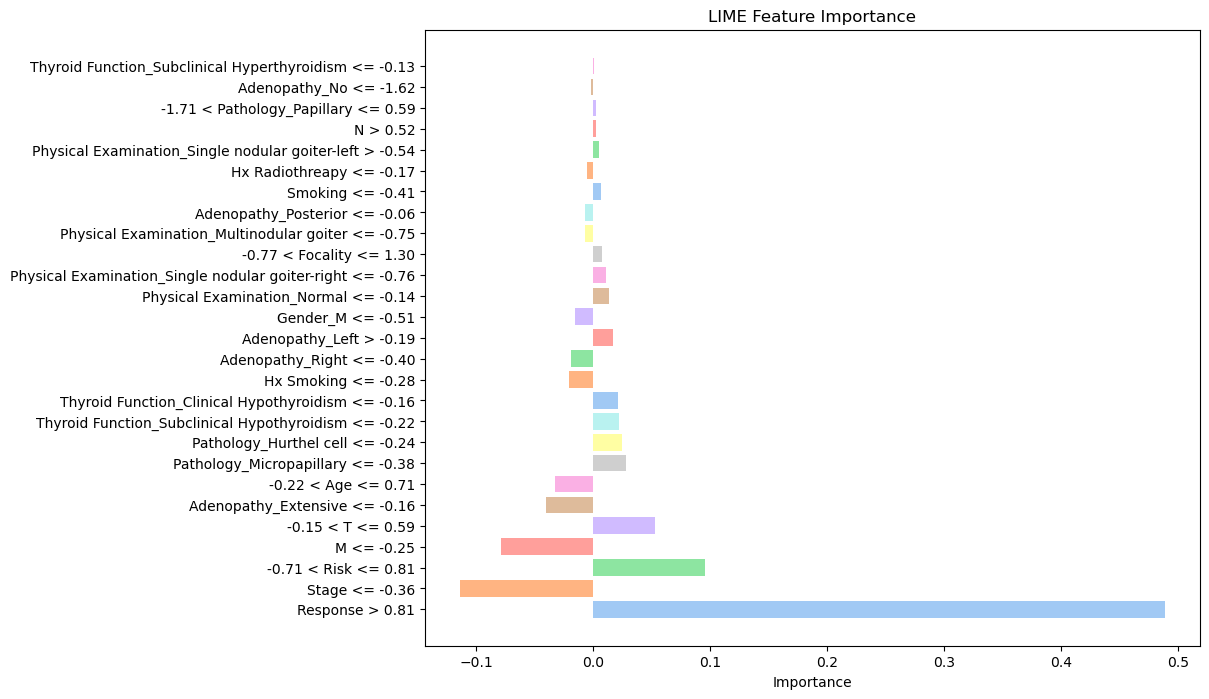

In [ ]:
plot_exp(exp_lime(rf), "Random Forest Classifier")


In [294]:
X_resampled, y_resampled = SMOTE().fit_resample(X_train_scaled, y_train)



RandomForestClassifier(random_state=42)

In [296]:
rf.fit(X_resampled, y_resampled)


RandomForestClassifier(bootstrap=False, class_weight='balanced',
                       max_features='log2', random_state=42)

In [298]:
y_pred_rf_1 = rf.predict(X_test_scaled)



Model Evaluation: 

Accuracy of the model is: 94.55 %
Precision of the model is: 100.00 %
Recall of the model is: 82.35 %
AUC value of the model is: 91.18 %
F1 score of the model is: 90.32 %

Classification Report: 



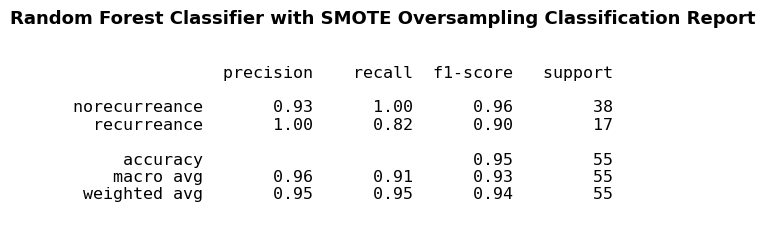


Confusion Matrix: 



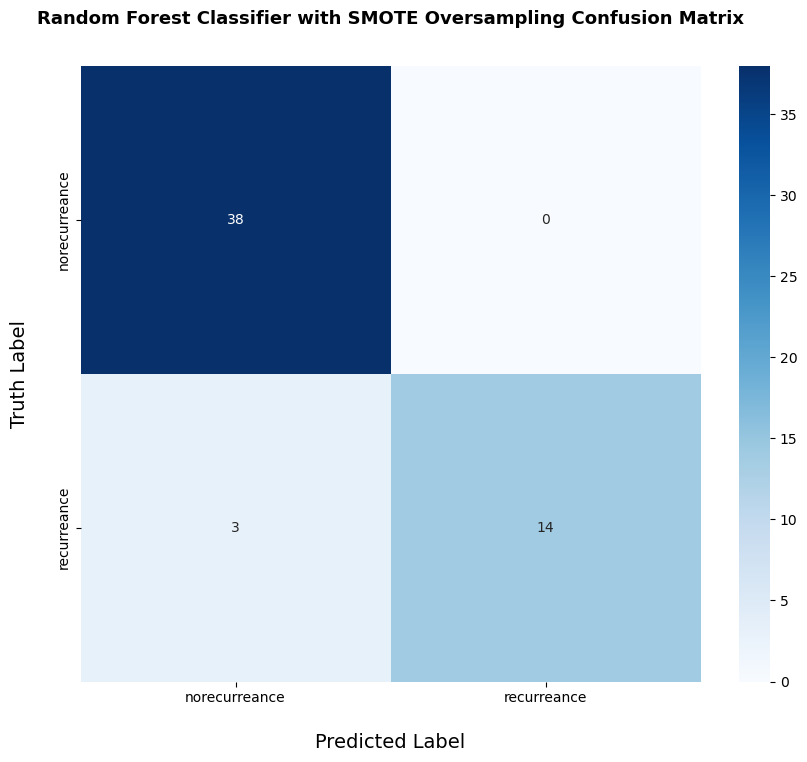

In [299]:
evaluate_model(y_test, y_pred_rf_1)
plot_cm_cr(y_test, y_pred_rf_1, "Random Forest Classifier with SMOTE Oversampling")


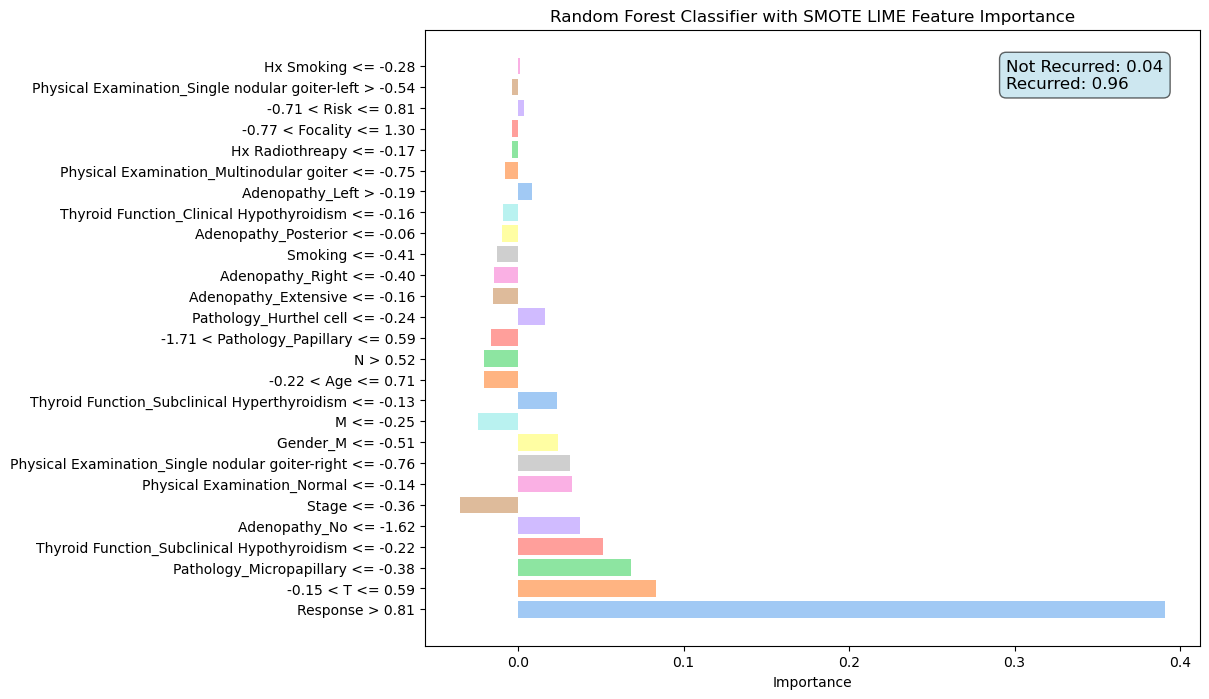

In [346]:
plot_exp(exp_lime(rf), "Random Forest Classifier with SMOTE")


LOGISTIC REGRESSION

In [376]:
log_reg = LogisticRegression(max_iter=1000)

C = [0.01, 0.1, 1, 10, 100]
solver = ['liblinear', 'lbfgs']
penalty = ['l1', 'l2']
log_reg_param_grid = dict(C=C, solver=solver, penalty=penalty)
grid_log_reg = GridSearchCV(log_reg, log_reg_param_grid, cv=5, scoring='recall', n_jobs=-1)
grid_log_reg.fit(X_val_scaled, y_val)
print(f"Logistic Regression Best Params: {grid_log_reg.best_params_} with score: {grid_log_reg.best_score_:.4f}")



Logistic Regression Best Params: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'} with score: 1.0000


In [378]:
log_reg.set_params(**grid_log_reg.best_params_)
log_reg.fit(X_train_scaled, y_train)


LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')

In [379]:
y_pred_log_reg = log_reg.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 92.73 %
Precision of the model is: 100.00 %
Recall of the model is: 76.47 %
AUC value of the model is: 88.24 %
F1 score of the model is: 86.67 %

Classification Report: 



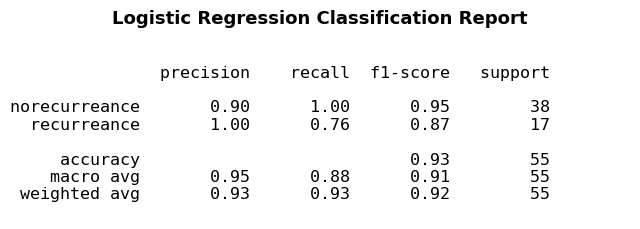


Confusion Matrix: 



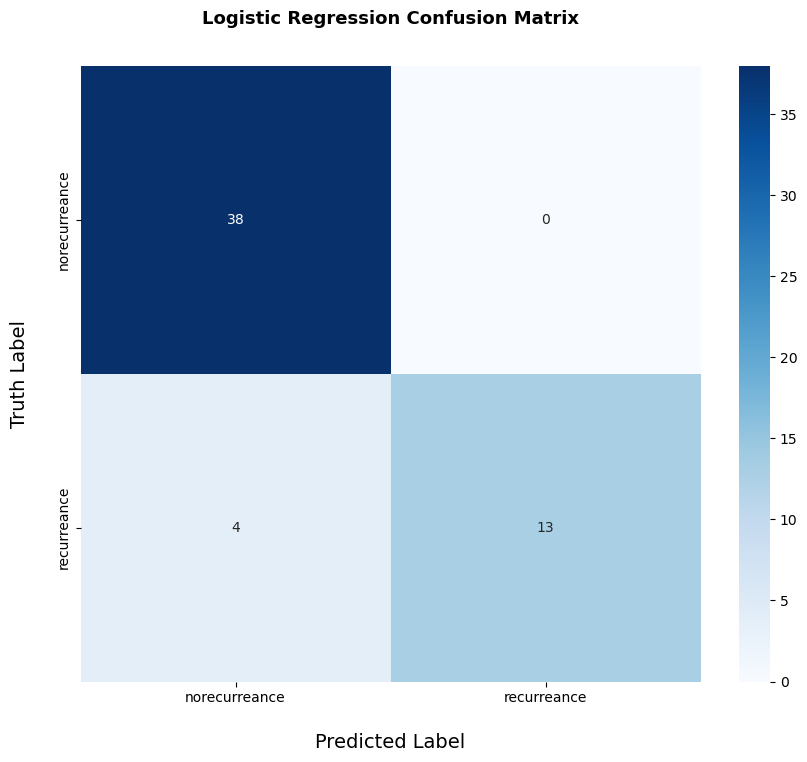

In [409]:
evaluate_model(y_test, y_pred_log_reg)
plot_cm_cr(y_test, y_pred_log_reg, "Logistic Regression")


In [381]:
kf_log_reg = kf_train(LogisticRegression(max_iter=1000), X, y, transformer, scaler)


Fold 1: Accuracy score: 0.97
Fold 2: Accuracy score: 0.96
Fold 3: Accuracy score: 0.95
Fold 4: Accuracy score: 0.95
Fold 5: Accuracy score: 0.99
Average accuracy score : 0.96


In [382]:
len(X_val_scaled[1])


28

In [404]:
plot_exp(exp_lime(log_reg), "Logistic Regression")


In [405]:
log_reg.fit(X_resampled, y_resampled)


LogisticRegression(C=0.1, max_iter=1000, penalty='l1', solver='liblinear')

In [406]:
y_pred_log_reg_1 = log_reg.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 90.91 %
Precision of the model is: 87.50 %
Recall of the model is: 82.35 %
AUC value of the model is: 88.54 %
F1 score of the model is: 84.85 %

Classification Report: 




Confusion Matrix: 



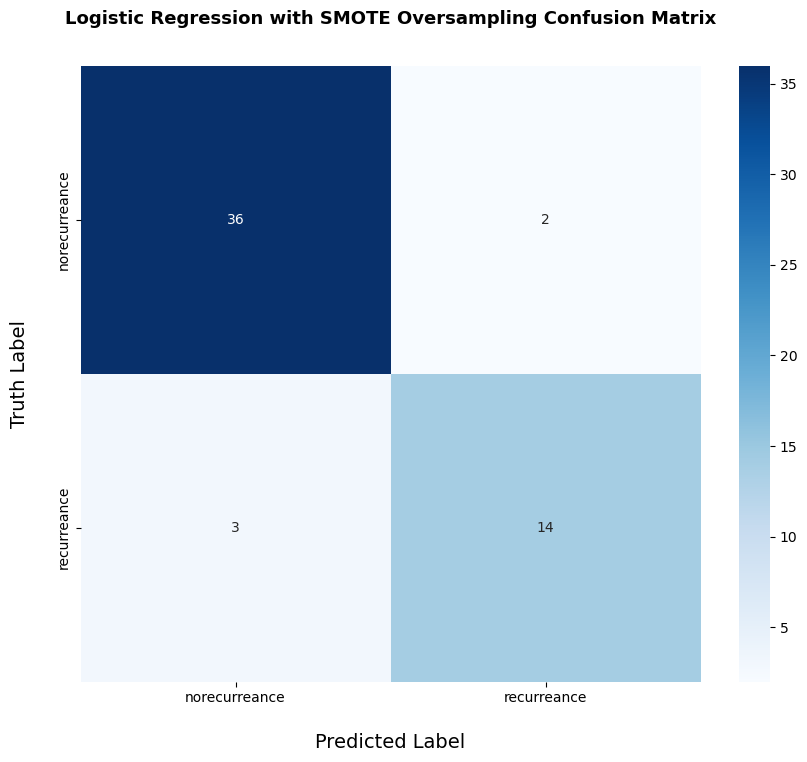

In [407]:
evaluate_model(y_test, y_pred_log_reg_1)
plot_cm_cr(y_test, y_pred_log_reg_1, "Logistic Regression with SMOTE Oversampling")


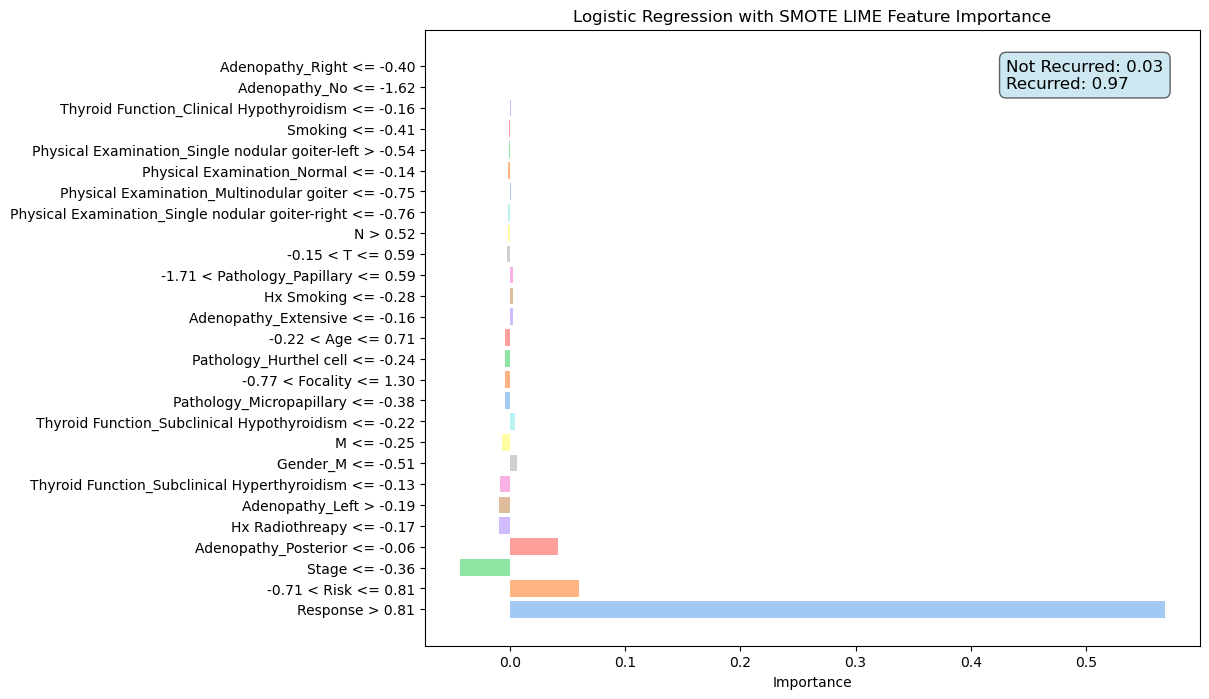

In [418]:
plot_exp(exp_lime(log_reg), "Logistic Regression with SMOTE")


SVM

In [408]:
svm_clsfr = SVC(probability=True)

C = [0.1, 1, 10, 100]
kernel = ['linear', 'rbf', 'poly']
gamma = ['scale', 'auto']

svm_param_grid = dict(C=C, kernel=kernel, gamma=gamma)

grid_search_svm = GridSearchCV(estimator=svm_clsfr,param_grid=svm_param_grid,cv=5,scoring='recall',n_jobs=-1)
grid_result_svm = grid_search_svm.fit(X_val_scaled, y_val)
print("Best Recall Score is achieved using the parameters : ", grid_result_svm.best_params_)



Best Recall Score is achieved using the parameters :  {'C': 0.1, 'gamma': 'scale', 'kernel': 'linear'}


In [410]:
svm_clsfr.set_params(**grid_result_svm.best_params_)

svm_clsfr.fit(X_train_scaled, y_train)

y_pred_svm = svm_clsfr.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_svm)
print("Accuracy:", accuracy)


Accuracy: 0.9454545454545454


Model Evaluation: 

Accuracy of the model is: 94.55 %
Precision of the model is: 100.00 %
Recall of the model is: 82.35 %
AUC value of the model is: 91.18 %
F1 score of the model is: 90.32 %

Classification Report: 



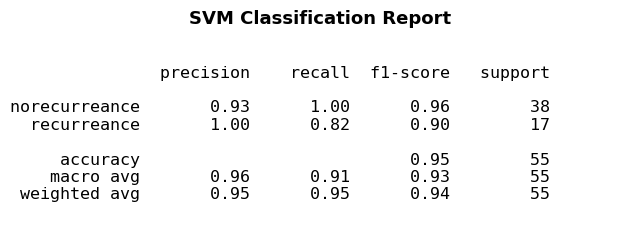


Confusion Matrix: 



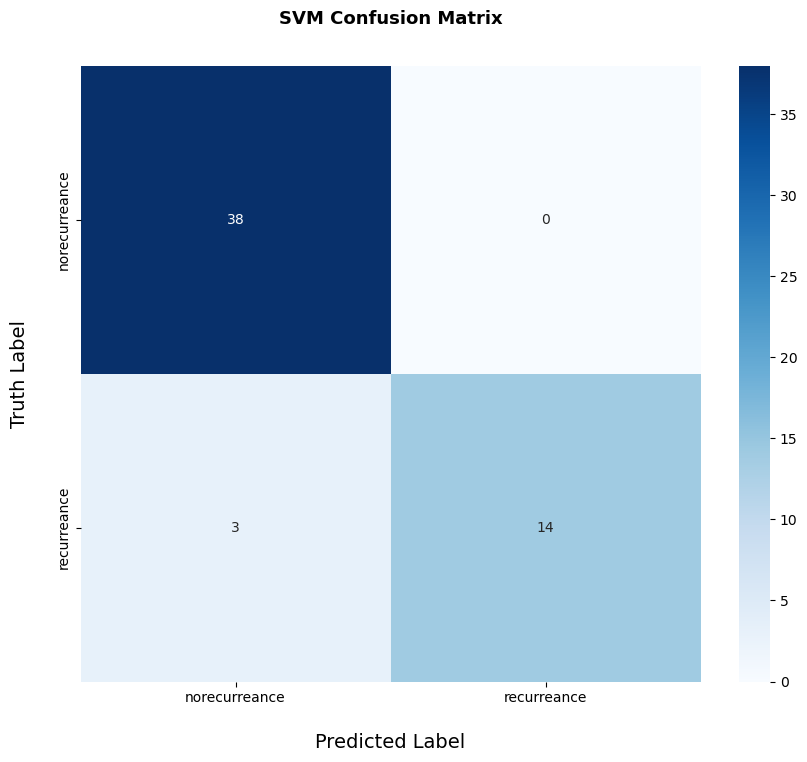

In [411]:
evaluate_model(y_test, y_pred_svm)
plot_cm_cr(y_test, y_pred_svm, "SVM")


In [412]:
kf_train(SVC(probability=True), X, y, transformer, scaler)


Fold 1: Accuracy score: 0.93
Fold 2: Accuracy score: 0.96
Fold 3: Accuracy score: 0.96
Fold 4: Accuracy score: 0.93
Fold 5: Accuracy score: 0.93
Average accuracy score : 0.94


0.9305555555555556

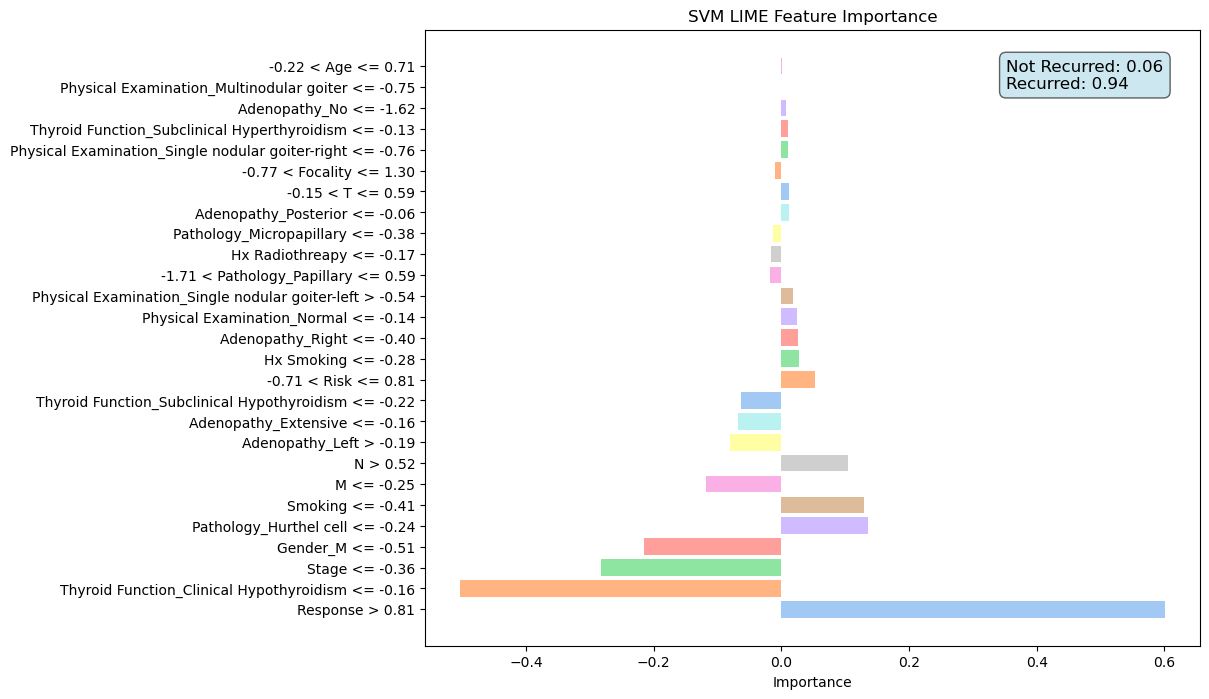

In [413]:
plot_exp(exp_lime(svm_clsfr), "SVM")


In [414]:
svm_clsfr.fit(X_resampled, y_resampled)


SVC(C=0.1, kernel='linear', probability=True)

In [415]:
y_pred_svm_1 = svm_clsfr.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 96.36 %
Precision of the model is: 100.00 %
Recall of the model is: 88.24 %
AUC value of the model is: 94.12 %
F1 score of the model is: 93.75 %

Classification Report: 



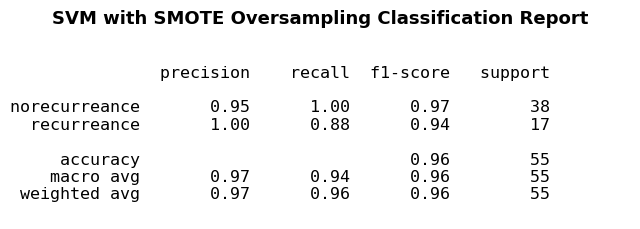


Confusion Matrix: 



In [416]:
evaluate_model(y_test, y_pred_svm_1)
plot_cm_cr(y_test, y_pred_svm_1, "SVM with SMOTE Oversampling")


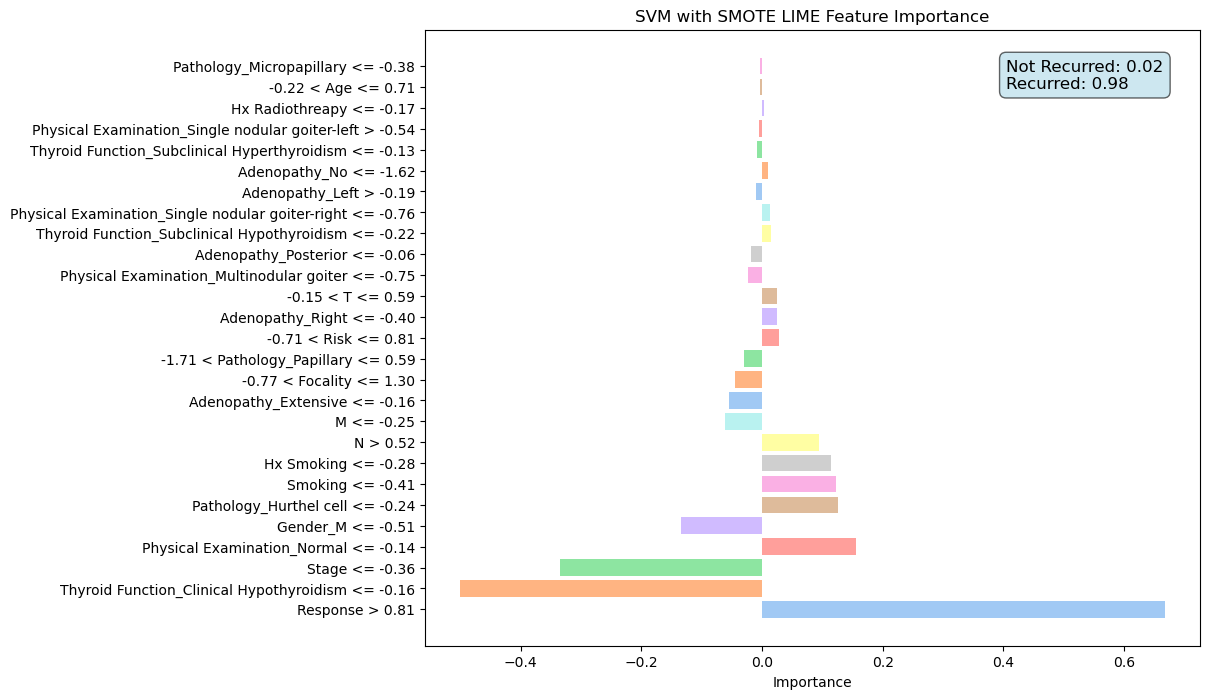

In [417]:
plot_exp(exp_lime(svm_clsfr), "SVM with SMOTE")


ADABoost

In [426]:
ada_clsfr = AdaBoostClassifier()

n_estimators = [50, 100, 200]
learning_rate = [0.01, 0.1, 1, 10]

ada_param_grid = dict(n_estimators=n_estimators, learning_rate=learning_rate)
grid_search_ada = GridSearchCV(estimator=ada_clsfr,param_grid=ada_param_grid,cv=5,scoring='recall',n_jobs=-1)

grid_result_ada = grid_search_ada.fit(X_val_scaled, y_val)

print("Best Recall Score is achieved using the parameters : ", grid_result_ada.best_params_)


Best Recall Score is achieved using the parameters :  {'learning_rate': 0.01, 'n_estimators': 100}


In [427]:
ada_clsfr.set_params(**grid_result_ada.best_params_)
ada_clsfr.fit(X_train_scaled, y_train)

y_pred_ada = ada_clsfr.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_ada)
print("Accuracy:", accuracy)


Accuracy: 0.9272727272727272


Model Evaluation: 

Accuracy of the model is: 92.73 %
Precision of the model is: 100.00 %
Recall of the model is: 76.47 %
AUC value of the model is: 88.24 %
F1 score of the model is: 86.67 %

Classification Report: 



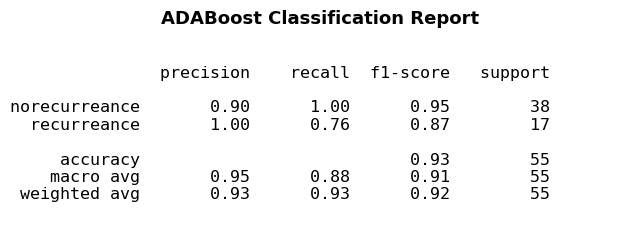


Confusion Matrix: 



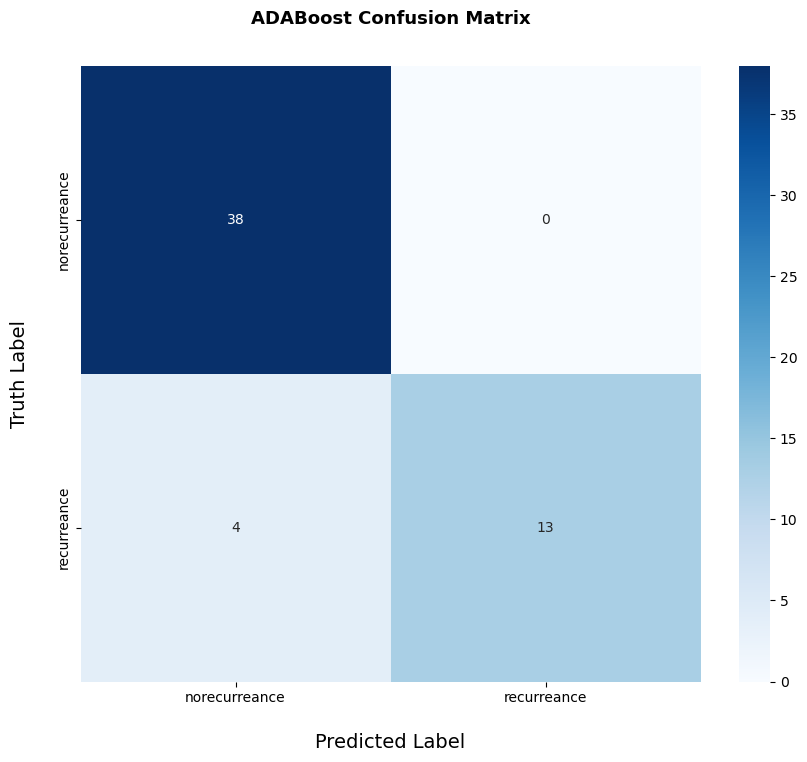

In [428]:
evaluate_model(y_test, y_pred_ada)
plot_cm_cr(y_test, y_pred_ada, "ADABoost")


In [429]:
kf_train(AdaBoostClassifier(), X, y, transformer, scaler)


Fold 1: Accuracy score: 0.96
Fold 2: Accuracy score: 0.97
Fold 3: Accuracy score: 0.96
Fold 4: Accuracy score: 0.90
Fold 5: Accuracy score: 0.99
Average accuracy score : 0.96


0.9861111111111112

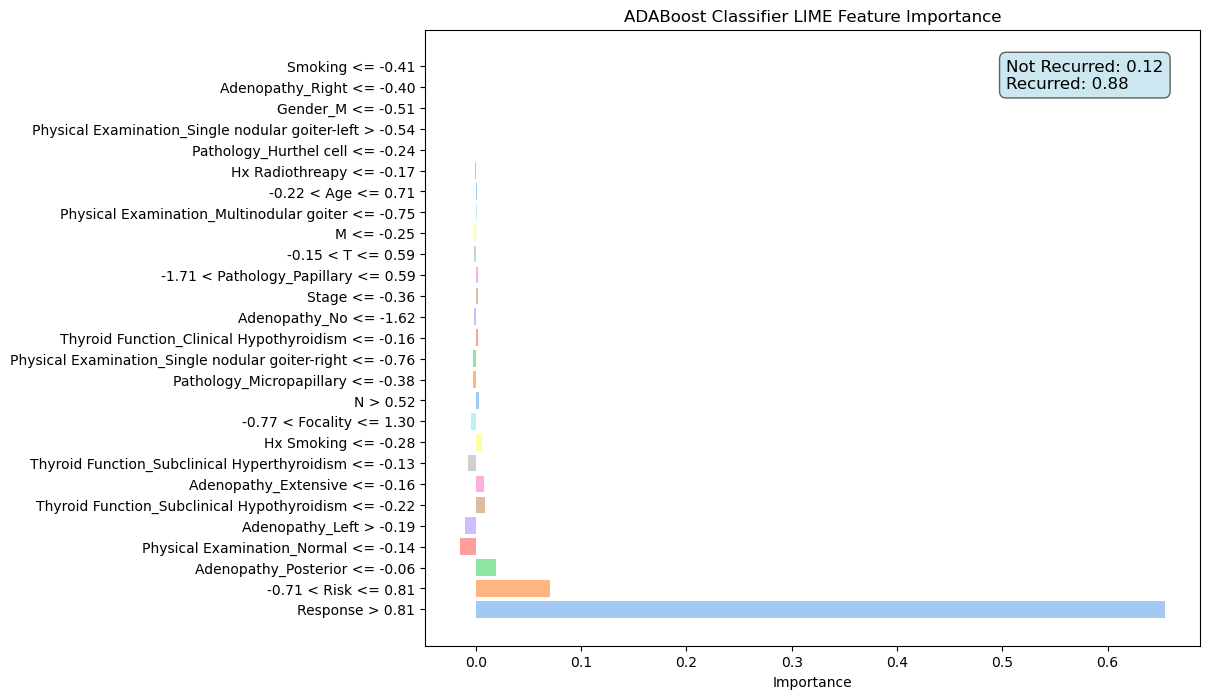

In [430]:
plot_exp(exp_lime(ada_clsfr), "ADABoost Classifier")


In [431]:
ada_clsfr.fit(X_resampled, y_resampled)


AdaBoostClassifier(learning_rate=0.01, n_estimators=100)

In [432]:
y_pred_ada_1 = ada_clsfr.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 92.73 %
Precision of the model is: 100.00 %
Recall of the model is: 76.47 %
AUC value of the model is: 88.24 %
F1 score of the model is: 86.67 %

Classification Report: 



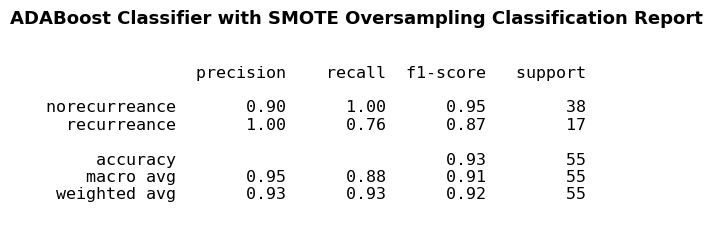


Confusion Matrix: 



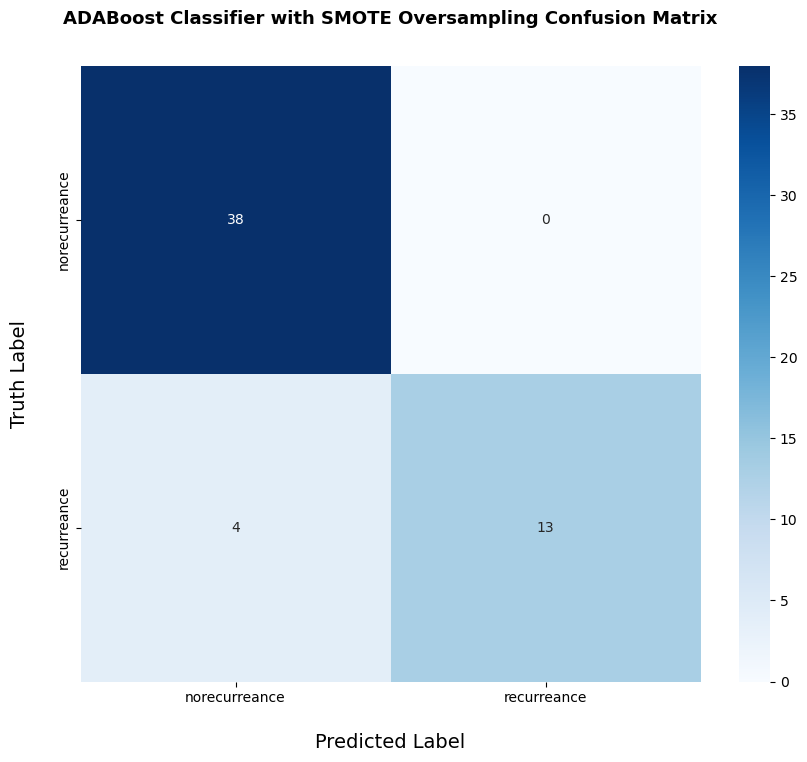

In [433]:
evaluate_model(y_test, y_pred_ada_1)
plot_cm_cr(y_test, y_pred_ada_1, "ADABoost Classifier with SMOTE Oversampling")


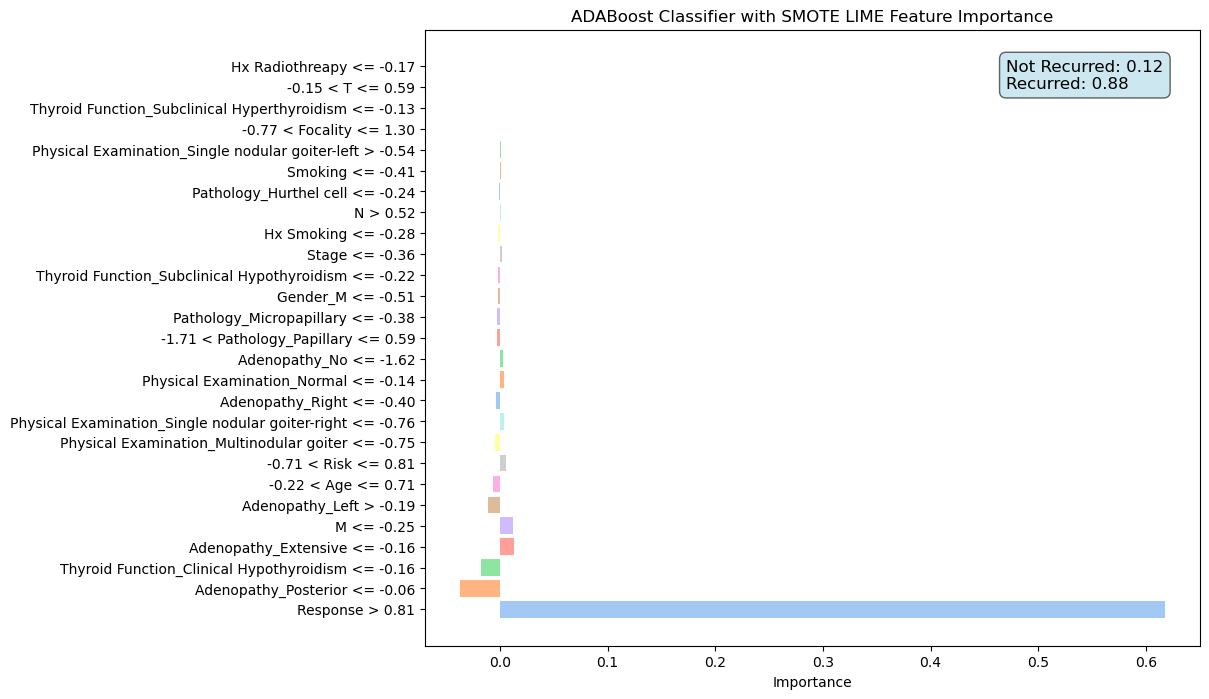

In [434]:
plot_exp(exp_lime(ada_clsfr), "ADABoost Classifier with SMOTE")


XGBoost

In [435]:
xgb_clsfr = XGBClassifier(use_label_encoder=False, eval_metric='logloss')
n_estimators = [100, 300, 500, 700, 1000]
subsample = [0.3, 0.5, 0.7, 1.0]
max_depth = [2, 4, 6, 7, 9]

xgb_param_grid = dict(n_estimators=n_estimators,subsample=subsample, max_depth=max_depth)

grid_search_xgb = GridSearchCV(estimator=xgb_clsfr,param_grid=xgb_param_grid,cv=5,scoring='roc_auc', n_jobs=-1)

grid_result_xgb = grid_search_xgb.fit(X_val_scaled, y_val)
print("Best ROC AUC Score is achieved using the parameters : ", grid_result_xgb.best_params_)


Best ROC AUC Score is achieved using the parameters :  {'max_depth': 2, 'n_estimators': 100, 'subsample': 0.7}


In [436]:
xgb_clsfr.set_params(**grid_result_xgb.best_params_)

xgb_clsfr.fit(X_train_scaled, y_train)

y_pred_xgb = xgb_clsfr.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_xgb)
print("Accuracy:", accuracy)


Accuracy: 0.9454545454545454


In [437]:
evaluate_model(y_test, y_pred_xgb)
plot_cm_cr(y_test, y_pred_xgb, "XGB Classifier")


Model Evaluation: 

Accuracy of the model is: 94.55 %
Precision of the model is: 100.00 %
Recall of the model is: 82.35 %
AUC value of the model is: 91.18 %
F1 score of the model is: 90.32 %

Classification Report: 




Confusion Matrix: 



In [441]:
kf_train(XGBClassifier(), X, y, transformer, scaler)


Fold 1: Accuracy score: 0.93
Fold 2: Accuracy score: 0.97
Fold 3: Accuracy score: 0.96
Fold 4: Accuracy score: 0.95
Fold 5: Accuracy score: 0.99
Average accuracy score : 0.96


In [445]:
plot_exp(exp_lime(xgb_clsfr), "XGB")


In [446]:
xgb_clsfr.fit(X_resampled, y_resampled)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric='logloss',
              feature_types=None, gamma=None, grow_policy=None,
              importance_type=None, interaction_constraints=None,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=2,
              max_leaves=None, min_child_weight=None, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100,
              n_jobs=None, num_parallel_tree=None, random_state=None, ...)

In [447]:
y_pred_xgb_1 = xgb_clsfr.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 94.55 %
Precision of the model is: 100.00 %
Recall of the model is: 82.35 %
AUC value of the model is: 91.18 %
F1 score of the model is: 90.32 %

Classification Report: 



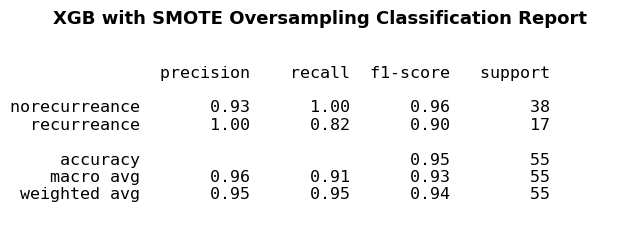


Confusion Matrix: 



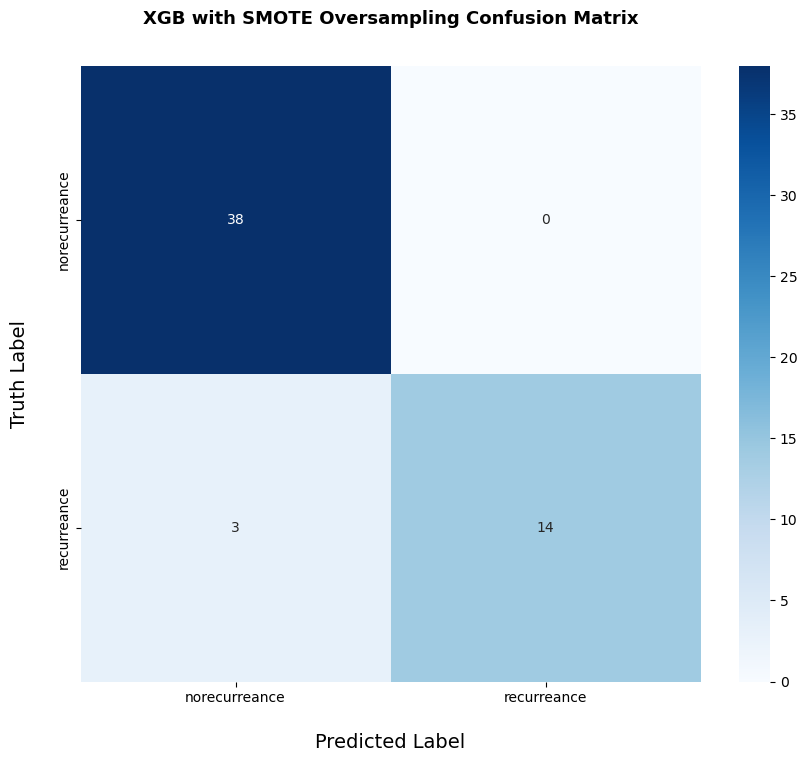

In [448]:
evaluate_model(y_test, y_pred_xgb_1)
plot_cm_cr(y_test, y_pred_xgb_1, "XGB with SMOTE Oversampling")


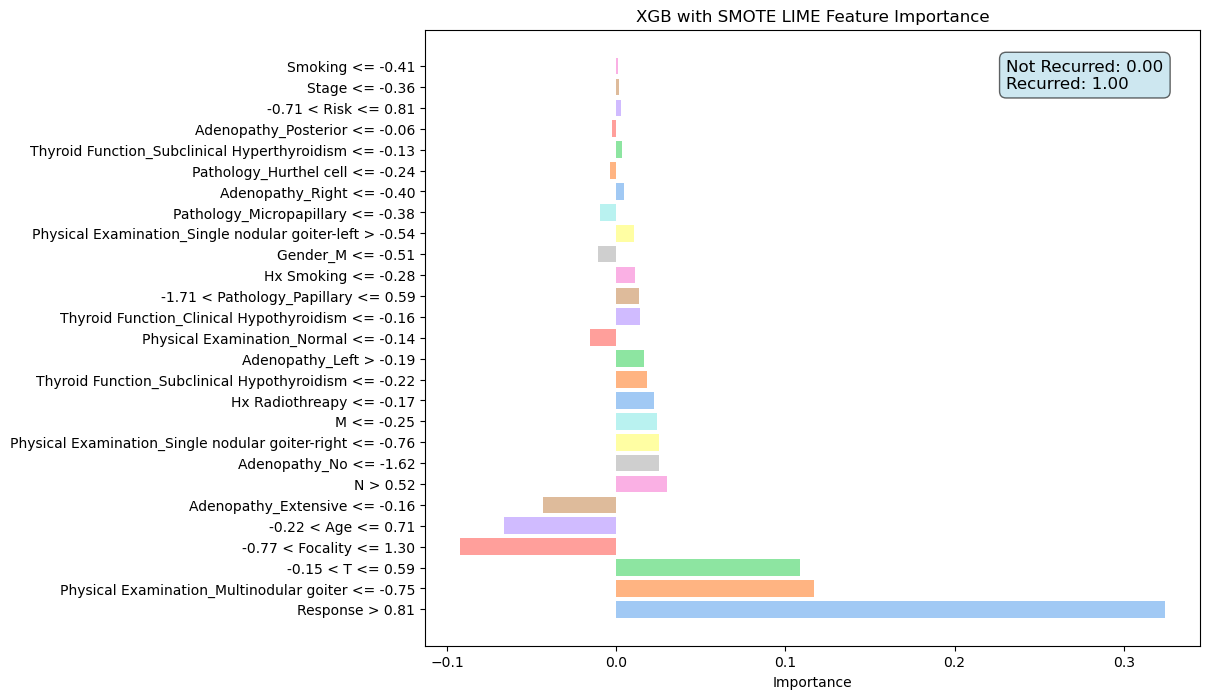

In [449]:
plot_exp(exp_lime(xgb_clsfr), "XGB with SMOTE")


Gaussian Naive Bayes

In [451]:
from sklearn.naive_bayes import GaussianNB


In [453]:
gnb_clsfr = GaussianNB()

gnb_clsfr.fit(X_train_scaled, y_train)
y_pred_gnb = gnb_clsfr.predict(X_test_scaled)

accuracy = accuracy_score(y_test, y_pred_gnb)
print("Accuracy:", accuracy)


Accuracy: 0.8909090909090909


Model Evaluation: 

Accuracy of the model is: 89.09 %
Precision of the model is: 100.00 %
Recall of the model is: 64.71 %
AUC value of the model is: 82.35 %
F1 score of the model is: 78.57 %

Classification Report: 




Confusion Matrix: 



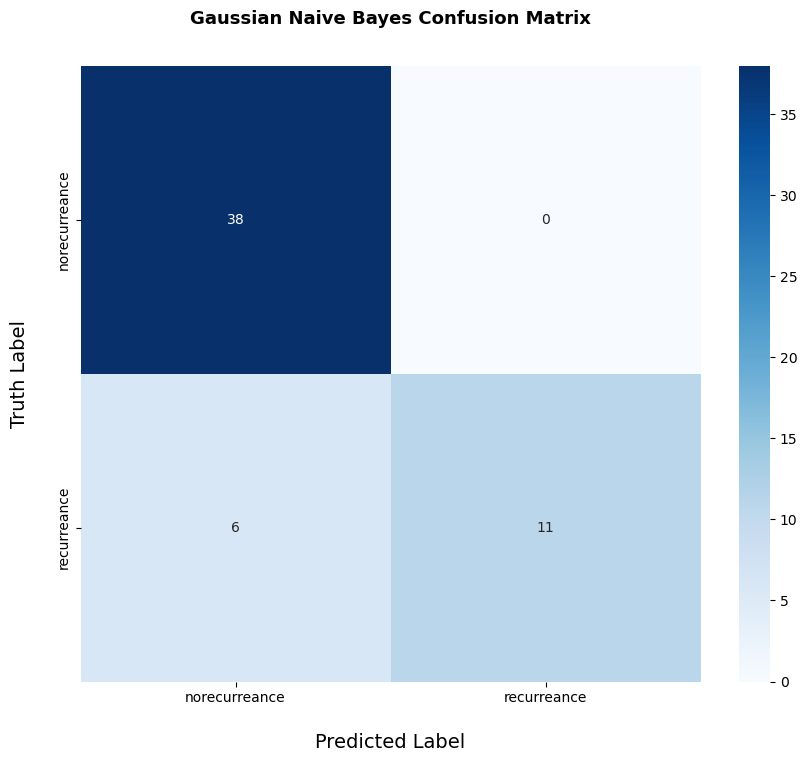

In [454]:
evaluate_model(y_test, y_pred_gnb)
plot_cm_cr(y_test, y_pred_gnb, "Gaussian Naive Bayes")


In [455]:
kf_train(GaussianNB(), X, y, transformer, scaler)


Fold 1: Accuracy score: 0.93
Fold 2: Accuracy score: 0.82
Fold 3: Accuracy score: 0.90
Fold 4: Accuracy score: 0.90
Fold 5: Accuracy score: 0.85
Average accuracy score : 0.88


In [456]:
plot_exp(exp_lime(gnb_clsfr), "Gaussian Naive Bayes")


In [469]:
gnb_clsfr.fit(X_resampled, y_resampled)


GaussianNB()

In [470]:
y_pred_gnb_1 = gnb_clsfr.predict(X_test_scaled)


In [472]:
evaluate_model(y_test, y_pred_gnb_1)
plot_cm_cr(y_test, y_pred_gnb_1, "Gaussian Naive Bayes with SMOTE Oversampling")


Model Evaluation: 

Accuracy of the model is: 92.73 %
Precision of the model is: 100.00 %
Recall of the model is: 76.47 %
AUC value of the model is: 88.24 %
F1 score of the model is: 86.67 %

Classification Report: 




Confusion Matrix: 



KNN

In [457]:
knn_clsfr = KNeighborsClassifier()
n_neighbors = [3, 5, 7, 9, 11]
weights = ['uniform', 'distance']
metric = ['euclidean', 'manhattan']
knn_param_grid = dict(n_neighbors=n_neighbors, weights=weights, metric=metric)
grid_search_knn = GridSearchCV(estimator=knn_clsfr,
                               param_grid=knn_param_grid,
                               cv=5,
                               scoring='recall',
                               n_jobs=-1)
grid_result_knn = grid_search_knn.fit(X_val_scaled, y_val)
print("Best Recall Score is achieved using the parameters : ", grid_result_knn.best_params_)


Best Recall Score is achieved using the parameters :  {'metric': 'euclidean', 'n_neighbors': 3, 'weights': 'uniform'}


In [458]:
knn_clsfr.set_params(**grid_result_knn.best_params_)
knn_clsfr.fit(X_train_scaled, y_train)
y_pred_knn = knn_clsfr.predict(X_test_scaled)
accuracy = accuracy_score(y_test, y_pred_knn)
print("Accuracy:", accuracy)


Accuracy: 0.9454545454545454


Model Evaluation: 

Accuracy of the model is: 94.55 %
Precision of the model is: 100.00 %
Recall of the model is: 82.35 %
AUC value of the model is: 91.18 %
F1 score of the model is: 90.32 %

Classification Report: 



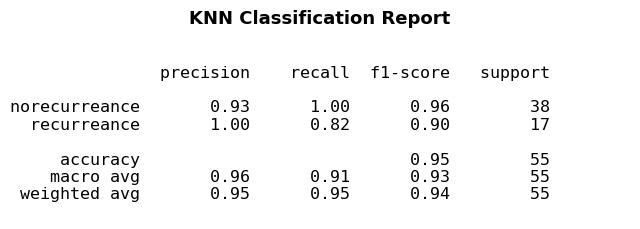


Confusion Matrix: 



In [459]:
evaluate_model(y_test, y_pred_knn)
plot_cm_cr(y_test, y_pred_knn, "KNN")


In [460]:
kf_train(KNeighborsClassifier(), X, y, transformer, scaler)


Fold 1: Accuracy score: 0.89
Fold 2: Accuracy score: 0.93
Fold 3: Accuracy score: 0.88
Fold 4: Accuracy score: 0.88
Fold 5: Accuracy score: 0.86
Average accuracy score : 0.89


In [461]:
plot_exp(exp_lime(knn_clsfr), "KNN")


In [466]:
knn_clsfr.fit(X_resampled, y_resampled)


KNeighborsClassifier(metric='euclidean', n_neighbors=3)

In [467]:
y_pred_knn_1 =  knn_clsfr.predict(X_test_scaled)


Model Evaluation: 

Accuracy of the model is: 90.91 %
Precision of the model is: 87.50 %
Recall of the model is: 82.35 %
AUC value of the model is: 88.54 %
F1 score of the model is: 84.85 %

Classification Report: 



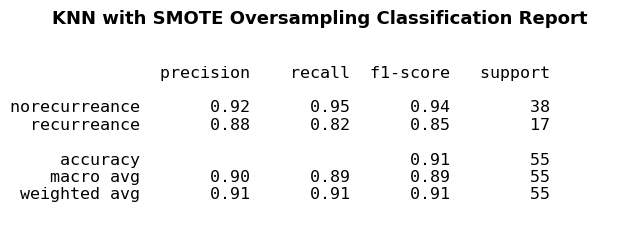


Confusion Matrix: 



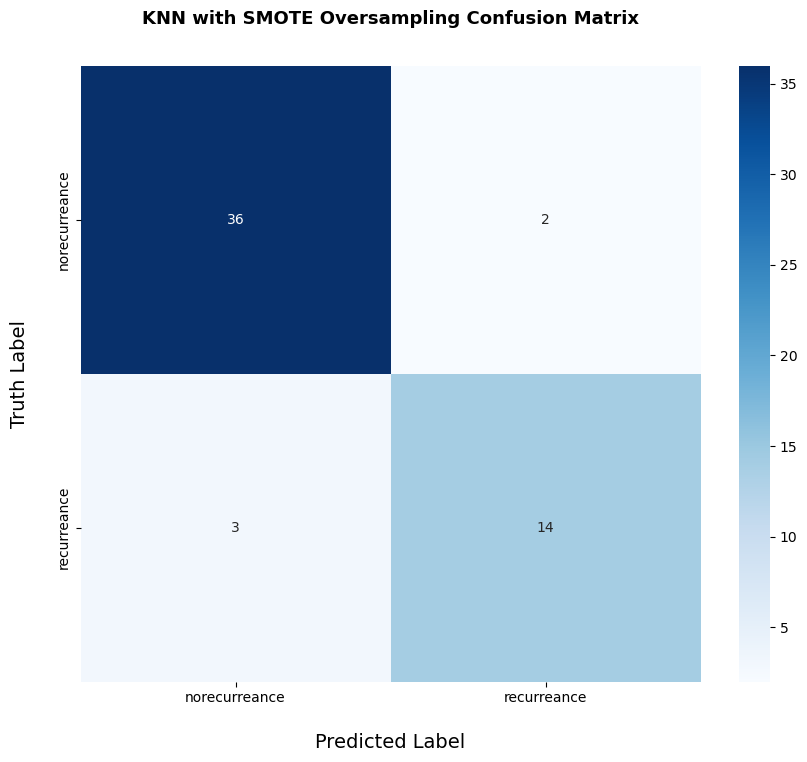

In [468]:
evaluate_model(y_test, y_pred_knn_1)
plot_cm_cr(y_test, y_pred_knn_1, "KNN with SMOTE Oversampling")


In [462]:
from sklearn.ensemble import VotingClassifier


In [478]:
ensemble_model = VotingClassifier(
    estimators=[
        ('rf', RandomForestClassifier()),
        ('xgb', XGBClassifier())
    ],
    voting='soft',
    n_jobs=-1
)


In [479]:
ensemble_model.fit(X_train_scaled, y_train)


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 n_jobs=-1, voting='soft')


--- Ensemble Evaluation (Random Forest + XGBoost) ---
Model Evaluation: 

Accuracy of the model is: 94.55 %
Precision of the model is: 100.00 %
Recall of the model is: 82.35 %
AUC value of the model is: 91.18 %
F1 score of the model is: 90.32 %

Classification Report: 



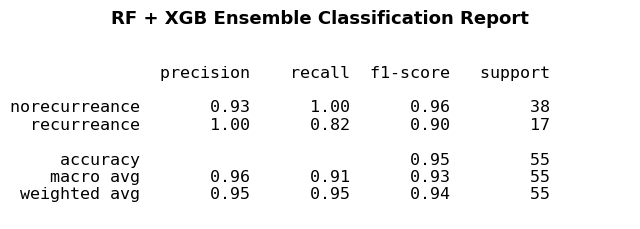


Confusion Matrix: 



In [480]:
y_pred_ensemble = ensemble_model.predict(X_test_scaled)

print("\n--- Ensemble Evaluation (Random Forest + XGBoost) ---")
evaluate_model(y_test, y_pred_ensemble)
plot_cm_cr(y_test, y_pred_ensemble, "RF + XGB Ensemble")


In [481]:
plot_exp(exp_lime(ensemble_model), "Ensemble Random Forest + XGBoost")


In [482]:
ensemble_model.fit(X_resampled, y_resampled)


VotingClassifier(estimators=[('rf', RandomForestClassifier()),
                             ('xgb',
                              XGBClassifier(base_score=None, booster=None,
                                            callbacks=None,
                                            colsample_bylevel=None,
                                            colsample_bynode=None,
                                            colsample_bytree=None, device=None,
                                            early_stopping_rounds=None,
                                            enable_categorical=False,
                                            eval_metric=None,
                                            feature_types=None, gamma=None,
                                            grow_policy=None,
                                            importance_type=None,
                                            interaction_constraints=None,
                                            learning_rate=None, max_bin=None,
                                            max_cat_threshold=None,
                                            max_cat_to_onehot=None,
                                            max_delta_step=None, max_depth=None,
                                            max_leaves=None,
                                            min_child_weight=None, missing=nan,
                                            monotone_constraints=None,
                                            multi_strategy=None,
                                            n_estimators=None, n_jobs=None,
                                            num_parallel_tree=None,
                                            random_state=None, ...))],
                 n_jobs=-1, voting='soft')

Model Evaluation: 

Accuracy of the model is: 94.55 %
Precision of the model is: 100.00 %
Recall of the model is: 82.35 %
AUC value of the model is: 91.18 %
F1 score of the model is: 90.32 %

Classification Report: 




Confusion Matrix: 



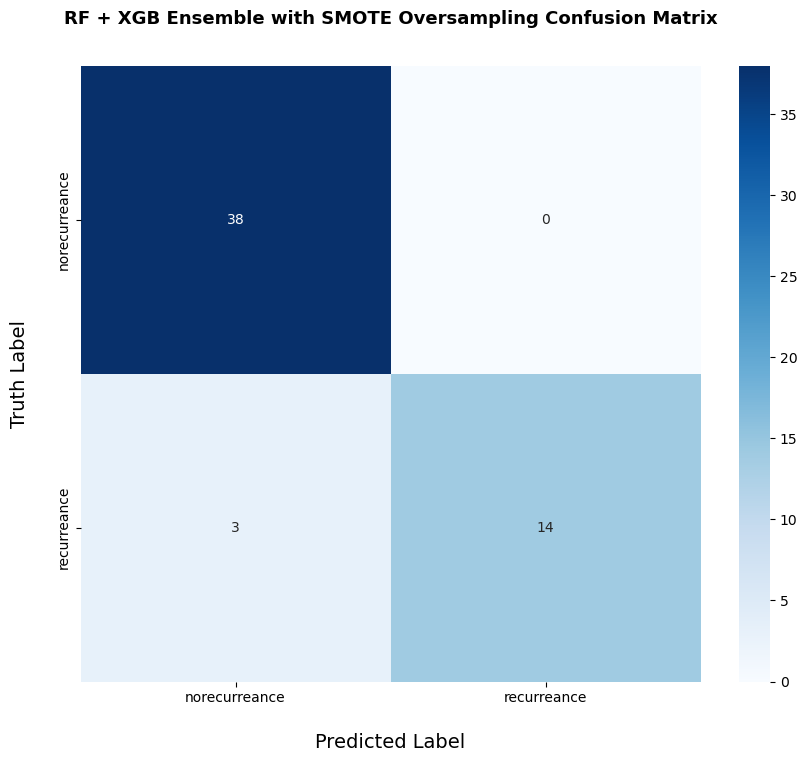

In [483]:
y_pred_ensemble_1 = ensemble_model.predict(X_test_scaled)

evaluate_model(y_test, y_pred_ensemble_1)
plot_cm_cr(y_test, y_pred_ensemble_1, "RF + XGB Ensemble with SMOTE Oversampling")



In [490]:
corr_matrix = transformed_df.corr()

plt.figure(figsize=(20, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f", linewidths=.5)
plt.title("Correlation Heatmap")
plt.show()


In [488]:
def plot_important_feature(model):
     feature_importances = model.feature_importances_

     features_df = pd.DataFrame({'Feature': final_feature_names, 'Importance': feature_importances})

     features_df = features_df.sort_values(by='Importance', ascending=False)

     plt.figure(figsize=(50, 25))
     plt.barh(features_df['Feature'], features_df['Importance'])
     plt.xlabel('Importance')
     plt.title('Random Forest Feature Importances')
     plt.show()


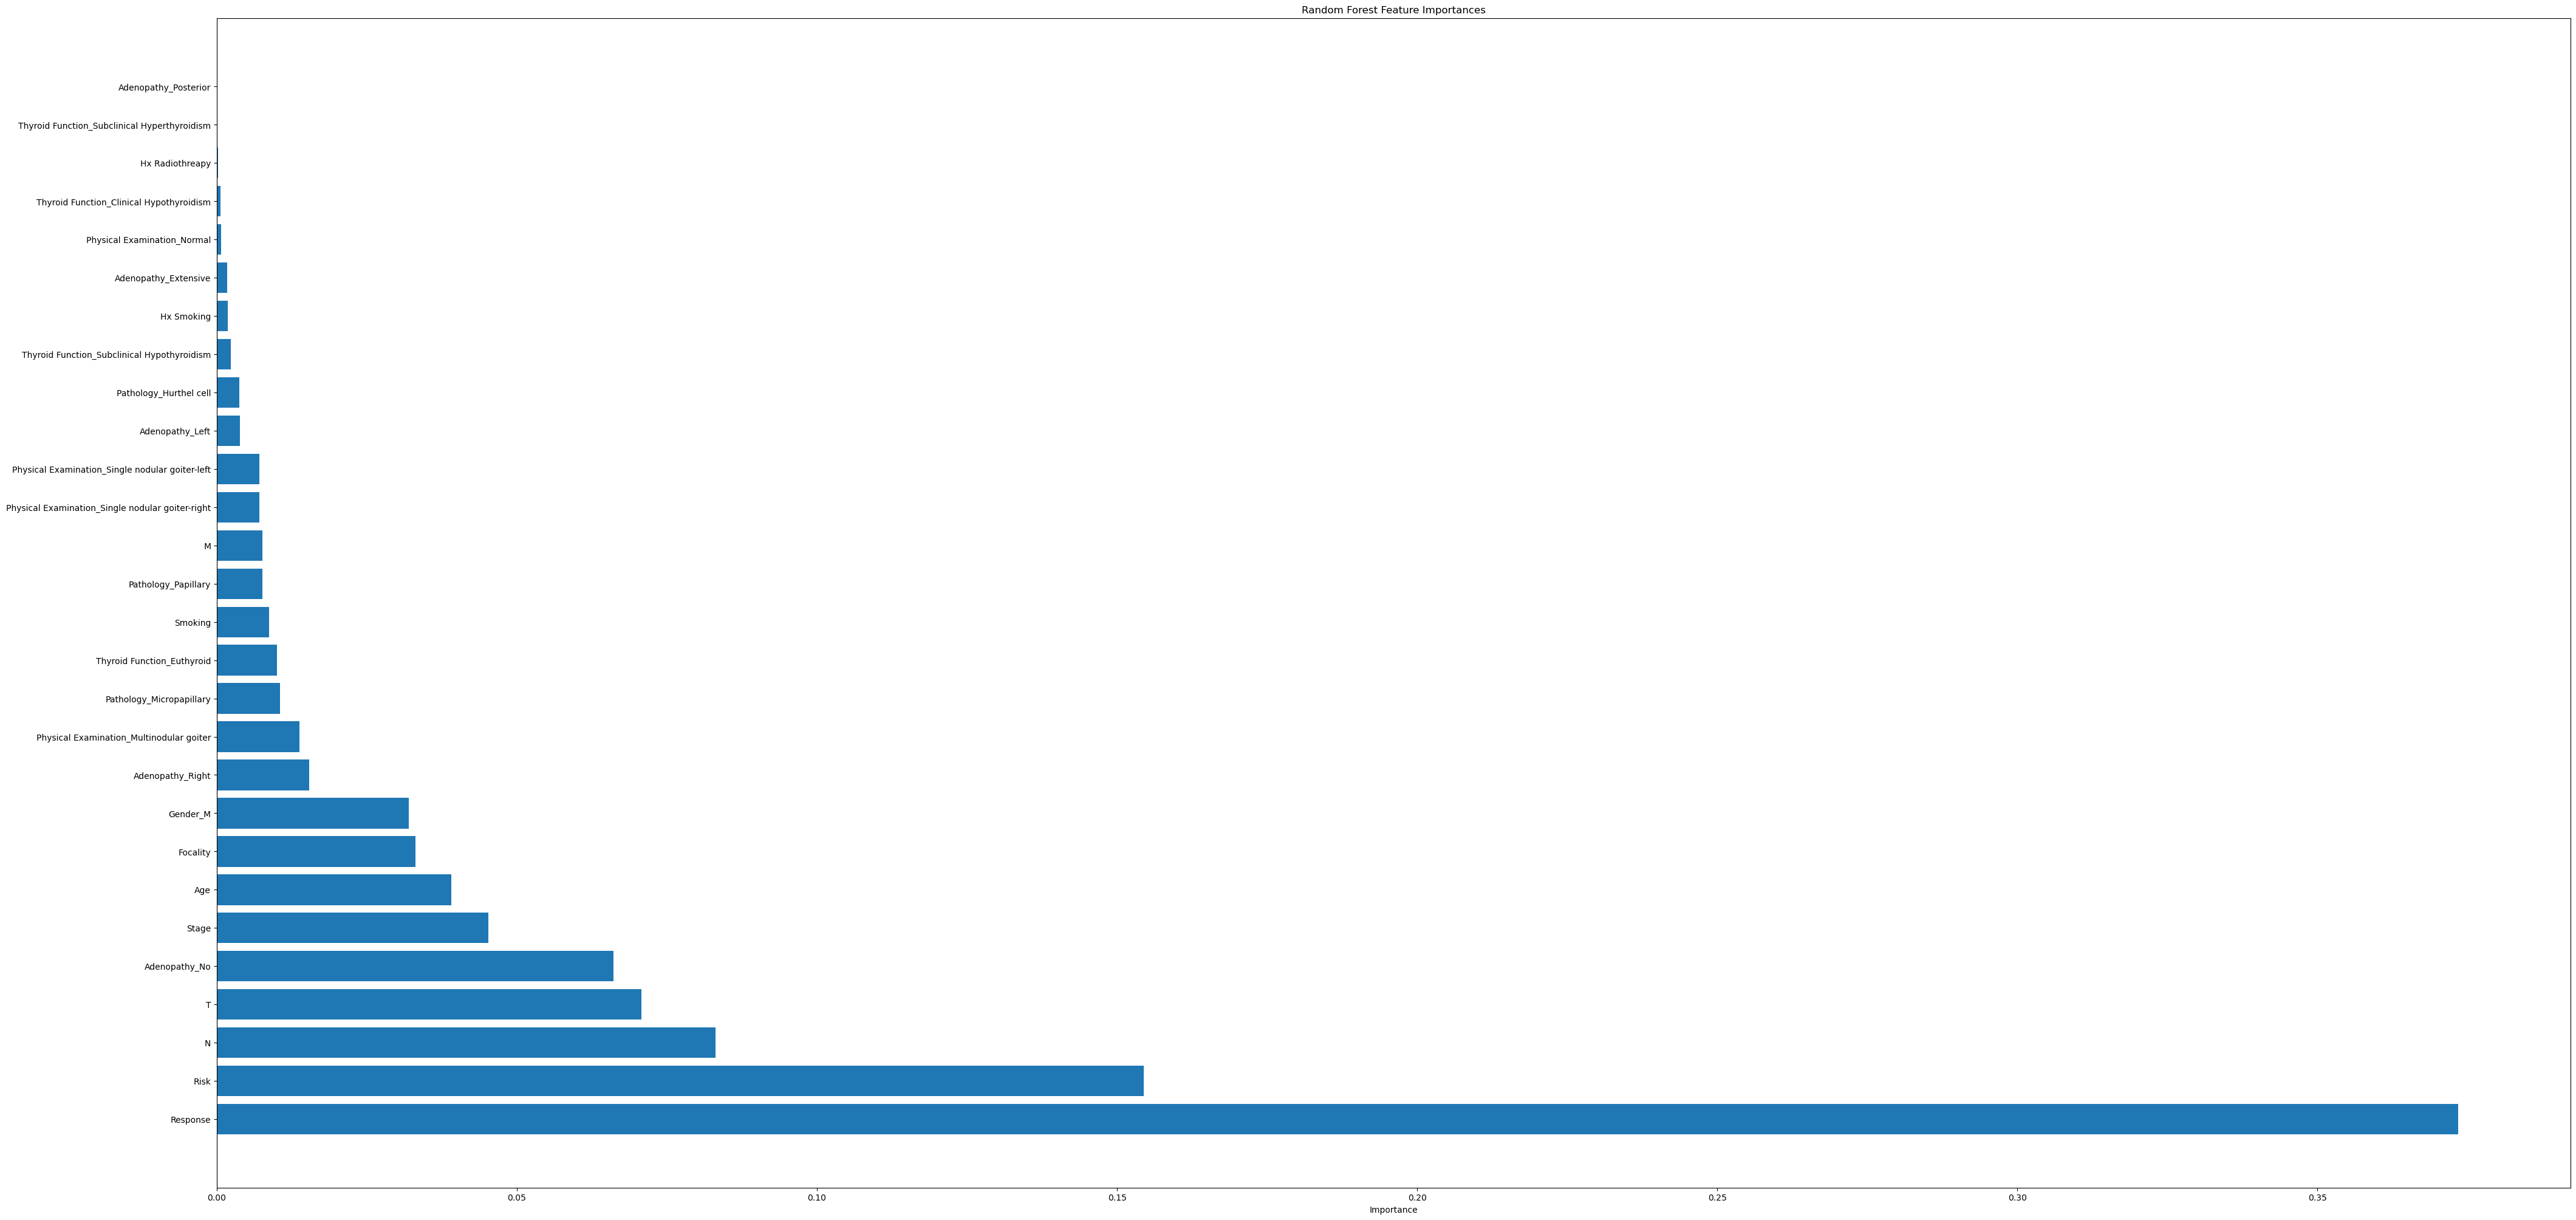

In [489]:
plot_important_feature(rf)
